<a href="https://colab.research.google.com/github/Inmacc96/HousePrice-PySpark/blob/main/HousePrice_CaballeroCarrero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Resumen

El objetivo de este trabajo es predecir el precio de la vivienda (**SalePrice**) a partir de 80 características de ésta. Para ello, comenzaremos con un preprocesado y exploración de los datos, en el que imputaremos los datos perdidos y convertiremos todas las variables categóricas a numéricas y a onehot. Esto lo hacemos con el fin de trabajar con las numéricas en modelos basados en árboles y las onehots en el resto. A pesar de esto, se realizará también los modelos basados en árboles con las variables onehots para compararlo con las numéricas.

Seguiremos con un breve estudio sobre la variable respuesta llegando a la conclusión de que es más adecuado trabajar con la transformación logarítmica de ésta.

Continuaremos realizando un análisis de componentes principales con el fin de reducir la dimensionalidad y de intentar arreglar el problema de multicolinealidad que se presenta entre las variables. En este proceso seleccionaremos el número de componentes principales siguiendo un criterio sobre la variabilidad explicada de las componentes.

A continuación, realizaremos un proceso de selección de componentes con el fin de quedarnos con aquellas que guarden relación con la variable respuesta **logSalePrice**. En este proceso utilizaremos la importancia de variables que nos da el modelo de **Random Forest**.

Por último, predeciremos el logaritmo  de la variable respuesta a partir de las componentes principales con las que nos hayamos quedado en la selección anterior. Los modelos que se usarán son los siguientes:
* Modelo lineal múltiple,
* Árbol de decisión,
* Random Forest,
* Gradient Boosting.

En este proceso se realizará un ajuste de hiperparámetros antes de entrenar cada uno de los modelos. Se utilizará el **rmse** como métrica de evaluación de los modelos.


## Inicialización

Instalación de Spark y Java

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://ftp.cixug.es/apache/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

Configuración variables de entorno


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

Abrimos conexión con Google Drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vamos a crear una variable con la ruta a nuestro directorio de trabajo.

In [ ]:
input_path = '/content/drive/My Drive/APBD/trabajo_final_APBD_2020/data/{}'
output_path= '/content/drive/My Drive/APBD/trabajo_final_APBD_2020/output/{}'

Conectamos el motor de ejecución de Spark con el entorno de Python que estamos usando.

In [ ]:
import findspark
findspark.init()

Finalmente, inicializamos la conexión con el motor de ejecución de Spark.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("nb06") \
    .getOrCreate()
spark

In [ ]:
spark.sparkContext.defaultParallelism

2

## Librerías utilizadas en el estudio


In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql import DataFrameStatFunctions as statFunc,Row
from pyspark.sql.functions import when
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, MaxAbsScaler, OneHotEncoderEstimator
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import log
from  pyspark.ml.feature import PCA
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from time import time

# Usaremos siempre la misma semilla.
global_seed = 99

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Lectura de los datos
Vamos a comenzar leyendo los datos con los que vamos a trabajar durante este trabajo.


In [ ]:
path_train = input_path.format("train.csv")
data_train = spark.read.csv(path_train,header=True, nullValue='NA', inferSchema=True, sep=",")
data_train.show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

In [ ]:
data_train.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [ ]:
n_filas_train = data_train.count()
n_col_train = len(data_train.columns)
print('El conjunto train tiene {} observaciones y {} variables.'.format(n_filas_train,n_col_train))

El conjunto train tiene 1460 observaciones y 81 variables.


In [ ]:
path_test = input_path.format("test.csv")
data_test = spark.read.csv(path_test,header=True,nullValue='NA', inferSchema=True, sep=",")
data_test.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgTy

In [ ]:
data_test.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [ ]:
n_filas_test = data_test.count()
n_col_test = len(data_test.columns)
print('El conjunto test tiene {} observaciones y {} variables.'.format(n_filas_test,n_col_test))

El conjunto test tiene 1459 observaciones y 80 variables.


Nótese que el conjunto **test** tiene una variable menos, que es la variable respuesta **SalePrice**.




## Preprocesado y exploración de los datos

### Imputación valores missing

En primer lugar, vamos a unir los datos **train** y **test**. Para poder unirlos adecuadamente:

*   Deben tener el mismo número de columnas.
*   Deben tener el mismo orden de columnas.
*   El tipo de cada variable debe ser el mismo en cada conjunto.

* Como vimos antes, al **data_test** le falta la variable respuesta **SalePrice**. Vamos a añadirla. 

In [ ]:
data_test = data_test.withColumn('SalePrice',F.lit(None).cast(IntegerType()))
data_test.show(5)

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

* Comprobamos que ambos conjuntos de datos tienen el mismo orden de columnas.

In [ ]:
print(data_train.columns)
print(data_test.columns)

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

* Por último, comprobamos que todas las variables en ambos conjuntos de datos tienen el mismo tipo.




In [ ]:
data_train.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [ ]:
data_test.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

Pasamos entonces a realizar la **unión** de ambos conjuntos.

In [ ]:
data_full = data_train.union(data_test)
print("Número de filas. data_traint: {} data_test: {} data_full: {}".format(data_train.count(), data_test.count(), data_full.count()))
data_full.show(5)

Número de filas. data_traint: 1460 data_test: 1459 data_full: 2919
+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandCont

#### Variables categóricas y numéricas

En primer lugar, vamos a ver cuántas variables **categóricas** y cuántas **numéricas** tenemos.


In [ ]:
vars_categoricas=[var.name for var in data_full.schema.fields if var.dataType == StringType()]
print(vars_categoricas)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [ ]:
vars_numericas=[var.name for var in data_full.schema.fields if var.dataType != StringType()]
print(vars_numericas)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


Vamos a **eliminar** la variable **Id** de la lista ya que es una variable que no nos va aportar nada en el estudio.

In [ ]:
vars_numericas = vars_numericas[1:]
print(vars_numericas)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [ ]:
print('Hay {} variables categóricas y {} variables numéricas.'.format(len(vars_categoricas),len(vars_numericas)))

Hay 43 variables categóricas y 37 variables numéricas.


A continuación, vamos a realizar un **resumen numérico** para las variables **numéricas** y otro para las variables **categóricas**.

In [ ]:
data_full.select(vars_numericas).describe().show()

+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|        MSSubClass|       LotFrontage|          LotArea|      OverallQual|       OverallCond|         YearBuilt|      YearRemodAdd|        MasVnrArea|        BsmtFinSF1|       BsmtFinSF2|        BsmtUnfSF|       TotalBsmtSF|          1stFlrSF|         2ndFlrSF|     LowQualFinSF|     

Podemos observar que hay algunas variables con valores faltantes como por ejemplo, **LotFrontage** o **MasVnrArea**. Más adelante trataremos de imputar estos valores.

In [ ]:
data_full.select(vars_categoricas).describe().show()

+-------+--------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+------------+-------+---------+----------+----------+-----------+----------+-----------+----------+------------+----------+----------+----------+------+-----+-----------+--------+-------------+
|summary|MSZoning|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|RoofStyle|RoofMatl|Exterior1st|Exterior2nd|MasVnrType|ExterQual|ExterCond|Foundation|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|Heating|HeatingQC|CentralAir|Electrical|KitchenQual|Functional|FireplaceQu|GarageType|GarageFinish|GarageQual|GarageCond|PavedDrive|PoolQC|Fence|MiscFeature|SaleType|SaleCondition|
+-------+--------+------+-----+--------+-----------+---------+---------+--------

Volvemos a observar variables con valores faltantes, algunas de ellas, con bastante como es el caso de **Alley** en el que sólo hay 198 filas rellenas. Esto se debe a que esta variable categórica tiene una clase que se denomina **NA** y por tanto lo cuenta como valor faltante. 

Las variables que presentan el problema anterior son:

* **Alley**
* **BsmtQual**
* **BsmtCond**
* **BsmtExposure**
* **BsmtFinType1**
* **BsmtFinType2**
* **FireplaceQu**
* **GarageType**
* **GarageFinish**
* **GarageQual**
* **GarageCond**
* **PoolQC**
* **Fence**
* **MiscFeature**



A continuación, vamos a obtener una lista con todas estas variables y vamos a imputar ese valor por otro nombre que le vamos a dar a esa categoría.

In [ ]:
var_categoria_NA = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1",
                    "BsmtFinType2","FireplaceQu","GarageType","GarageFinish",
                    "GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]
nomb_categoria_NA = ["NotNA"]*len(var_categoria_NA)
data_full_impt = data_full.fillna(dict(zip(var_categoria_NA,nomb_categoria_NA)))

Si volvemos a realizar el **resumen numérico** a las variables **categóricas**, podemos observar que muchas de ellas han dejado de tener valores faltantes.

In [ ]:
data_full_impt.select(vars_categoricas).describe().show()

+-------+--------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+------------+-------+---------+----------+----------+-----------+----------+-----------+----------+------------+----------+----------+----------+------+-----+-----------+--------+-------------+
|summary|MSZoning|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|RoofStyle|RoofMatl|Exterior1st|Exterior2nd|MasVnrType|ExterQual|ExterCond|Foundation|BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|Heating|HeatingQC|CentralAir|Electrical|KitchenQual|Functional|FireplaceQu|GarageType|GarageFinish|GarageQual|GarageCond|PavedDrive|PoolQC|Fence|MiscFeature|SaleType|SaleCondition|
+-------+--------+------+-----+--------+-----------+---------+---------+--------

#### Variables con missing

Vemos ahora cuántos valores faltantes hay para cada variable. De antemano, sabemos que la variable respuesta **SalePrice** va a tener 1459 valores faltantes.

In [ ]:
def count_nulls(c): 
    return F.sum(F.col(c).isNull().cast(IntegerType())).alias(c)

# Definimos la operación para cada columna del DF.
exprs = [count_nulls(c) for c in data_full_impt.columns]

# Aplicamos todas las operaciones.
data_full_impt.agg(*exprs).show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

Obtenemos ahora una lista con las variables con missing y el número de missing que tienen.

In [ ]:
var_con_NA = [(x,data_full_impt.agg(*exprs).select(x).collect()[0][0]) for x in data_full_impt.columns if data_full_impt.agg(*exprs).select(x).collect()[0][0]!=0]
var_con_NA

[('MSZoning', 4),
 ('LotFrontage', 486),
 ('Utilities', 2),
 ('Exterior1st', 1),
 ('Exterior2nd', 1),
 ('MasVnrType', 24),
 ('MasVnrArea', 23),
 ('BsmtFinSF1', 1),
 ('BsmtFinSF2', 1),
 ('BsmtUnfSF', 1),
 ('TotalBsmtSF', 1),
 ('Electrical', 1),
 ('BsmtFullBath', 2),
 ('BsmtHalfBath', 2),
 ('KitchenQual', 1),
 ('Functional', 2),
 ('GarageYrBlt', 159),
 ('GarageCars', 1),
 ('GarageArea', 1),
 ('SaleType', 1),
 ('SalePrice', 1459)]

In [ ]:
print('Hemos obtenido {} variables con valores faltantes.'.format(len(var_con_NA)))

Hemos obtenido 21 variables con valores faltantes.


A continuación, vamos a proceder al estudio de cada variable con missing y decidiremos qué valor es más adecuado imputar.

##### **MSZoning**

Esta variable representa la **clasificación general de venta por zonas**. 

Vamos a comenzar estudiando las viviendas a las que le falta este dato.



In [ ]:
miss_MSZoning = data_full_impt.filter(data_full_impt.MSZoning.isNull())
miss_MSZoning.show(5)

not_miss_MSZoning = data_full_impt.filter(data_full_impt.MSZoning.isNotNull())

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Para imputar esta variable, vamos a ver cuál es la zona(**MSZoning**) más frecuente para cada tipo de  vivienda(**MSSubClass**) ya que pensamos que pueden guardar una relación entre ellas.

In [ ]:
df1 = not_miss_MSZoning.groupBy(['MSSubClass','MSZoning']).count()
df1.filter(df1.MSSubClass == 30).show()
df1.filter(df1.MSSubClass == 20).show()
df1.filter(df1.MSSubClass == 70).show()

+----------+--------+-----+
|MSSubClass|MSZoning|count|
+----------+--------+-----+
|        30|      RH|    2|
|        30| C (all)|    8|
|        30|      RM|   67|
|        30|      RL|   61|
+----------+--------+-----+

+----------+--------+-----+
|MSSubClass|MSZoning|count|
+----------+--------+-----+
|        20|      FV|   34|
|        20|      RM|   20|
|        20| C (all)|    3|
|        20|      RH|    4|
|        20|      RL| 1016|
+----------+--------+-----+

+----------+--------+-----+
|MSSubClass|MSZoning|count|
+----------+--------+-----+
|        70|      RM|   63|
|        70| C (all)|    4|
|        70|      RH|    3|
|        70|      RL|   57|
+----------+--------+-----+



Podemos observar que a la vivienda de **tipo 20** podemos asociarle claramente la zona **RL** ya que destaca con diferencia. Sin embargo, a las viviendas de **tipo 30** y **70** podemos asociarle tanto la zona **RM** como la **RL**. Nosotros nos vamos a quedar con **RM**,  por ejemplo, en ambos casos.

In [ ]:
valimp_MSZoning = "RL"

Vamos a imputar ya el caso de la vivienda de tipo 20 y el resto lo imputaremos más adelante.

In [ ]:
data_full_impt = data_full_impt.withColumn('MSZoning', \
                  when((data_full_impt.MSZoning.isNull()) & (data_full_impt.MSSubClass==20),'RL') \
                  .otherwise(data_full_impt.MSZoning))

Comprobamos ahora que si filtramos por los valores nulos de **MSZoning** entonces las viviendas de **tipo 20 no** aparecen.

In [ ]:
data_full_impt.filter(data_full_impt.MSZoning.isNull()).show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

##### **LotFrontage**

Esta variable representa la **distancia entre la calle y la vivienda**. Al tener demasiados missing, vamos a estudiar la variable directamente en los casos donde no presenta missings.

In [ ]:
not_miss_LotFrontage = data_full_impt.filter(data_full_impt.LotFrontage.isNotNull())

* Calculamos la **media** de la variable.

In [ ]:
not_miss_LotFrontage.agg({'LotFrontage':'avg'}).show()

+-----------------+
| avg(LotFrontage)|
+-----------------+
|69.30579531442663|
+-----------------+



* Calculamos la **mediana** de la variable.

In [ ]:
statFunc(not_miss_LotFrontage).approxQuantile('LotFrontage', [0.5], 0.1)

[64.0]

* Calculamos un **resumen numérico** de la variable.

In [ ]:
not_miss_LotFrontage.describe('LotFrontage').show()

+-------+------------------+
|summary|       LotFrontage|
+-------+------------------+
|  count|              2433|
|   mean| 69.30579531442663|
| stddev|23.344904706927394|
|    min|                21|
|    max|               313|
+-------+------------------+



* Representamos un **boxplot** de la variable.

{'boxes': [<matplotlib.lines.Line2D at 0x7f74d29b2908>],
 'caps': [<matplotlib.lines.Line2D at 0x7f74d29cd358>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f74d29cddd8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f74d29cda58>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f74d29b2c18>,
  <matplotlib.lines.Line2D at 0x7f74d29b2f98>]}

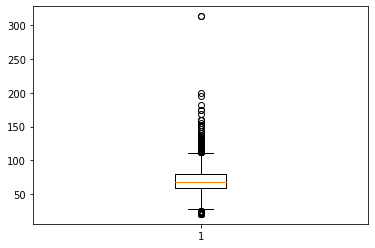

In [ ]:
plt.boxplot(not_miss_LotFrontage[['LotFrontage']].toPandas()['LotFrontage'])

Como podemos observar, esta variable presenta una desviación típica muy alta por lo que ni la media ni la mediana pondrían ser valores representativos para esta variable. Además cuando representamos el boxplot, vemos que tiene una gran cantidad de outliers. En consiguiente, creemos adecuado **eliminar** esta variable del estudio.

##### **Utilities**

Esta variable representa el **tipo de sevicio disponible**. 

Vamos a comenzar estudiando las viviendas a las que le falta este dato.

In [ ]:
miss_Utilities = data_full_impt.filter(data_full_impt.Utilities.isNull())
miss_Utilities.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

A continuación, investigamos el tipo de servicio (**Utilities**) según el tipo de la vivienda (**MSSubClass**) ya que pensamos que pueden guardar un relación entre ellas.

In [ ]:
not_miss_Utilities = data_full_impt.filter(data_full_impt.Utilities.isNotNull())

In [ ]:
not_miss_Utilities.filter(not_miss_Utilities.MSSubClass == 30).groupby('Utilities').count().orderBy(F.desc('count')).show()

+---------+-----+
|Utilities|count|
+---------+-----+
|   AllPub|  138|
+---------+-----+



In [ ]:
not_miss_Utilities.filter(not_miss_Utilities.MSSubClass == 20).groupby('Utilities').count().orderBy(F.desc('count')).show()

+---------+-----+
|Utilities|count|
+---------+-----+
|   AllPub| 1077|
|   NoSeWa|    1|
+---------+-----+



Podemos observar que en ambos tipos de vivienda, la mayoría tienen todos los servicios disponibles y además con diferencia. Por tanto, es lógico que imputemos **Utilities** por **AllPub**.

In [ ]:
valimp_Utilities = "AllPub"

##### **Exterior1st**

Esta variable representa el **material de la cubierta exterior de la casa**.

Comenzamos estudiando la vivienda a la que le falta esta variable.

In [ ]:
miss_Exterior1st = data_full_impt.filter(data_full_impt.Exterior1st.isNull())
miss_Exterior1st.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

En este caso creemos que es adecuado investigar a partir del material (**RoofMatl**) del tejado y calidad (**ExterQual**) y condición (**ExterCond**) del material que está hecho la cubierta exterior ya que pensamos que pueden estar relacionado con esta variable. Es por ello, que bajo las condiciones de las variables anteriores, vamos a quedarnos con el material  utilizado más frecuente.

In [ ]:
not_miss_Exterior1st = data_full_impt.filter(data_full_impt.Exterior1st.isNotNull())

In [ ]:
not_miss_Exterior1st.filter((not_miss_Exterior1st.RoofMatl == 'Tar&Grv') & \
                            (not_miss_Exterior1st.ExterQual== 'TA') & \
                            (not_miss_Exterior1st.ExterCond == 'TA')).groupby('Exterior1st') \
                            .count().show()

+-----------+-----+
|Exterior1st|count|
+-----------+-----+
|    HdBoard|    1|
|    WdShing|    2|
|    Plywood|    9|
|    Wd Sdng|    3|
|    BrkComm|    1|
+-----------+-----+



Observamos por tanto que  la mayoría de las viviendas, que tienen el **tejado** hecho de **grava y alquitrán** y la **condición** y **calidad** del material de la cubierta exterior es **media**, tienen la cubierta exterior de **madera contrachapada**.

In [ ]:
valimp_Exterior1st = "Plywood"

##### **Exterior2nd**

Esta variable representa el **material de la cubierta exterior de la casa si tiene más de un material**.

Comenzamos estudiando la vivienda que no presenta este dato.

In [ ]:
miss_Exterior2nd = data_full_impt.filter(data_full_impt.Exterior2nd.isNull())
miss_Exterior2nd.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Podemos observar que es la misma vivienda que antes. Por tanto, vamos a razonar de la misma manera, es decir, relacionamos **Exterior2nd** con las variables **ExterCond**, **ExterQual** y  **RootMatl**.

In [ ]:
not_miss_Exterior2nd = data_full_impt.filter(data_full_impt.Exterior2nd.isNotNull())

In [ ]:
not_miss_Exterior2nd.filter((not_miss_Exterior2nd.RoofMatl == 'Tar&Grv') & (not_miss_Exterior2nd.ExterQual== 'TA') & (not_miss_Exterior2nd.ExterCond == 'TA')).groupby('Exterior2nd').count().show()

+-----------+-----+
|Exterior2nd|count|
+-----------+-----+
|    HdBoard|    1|
|    Plywood|    8|
|    Wd Shng|    2|
|    Wd Sdng|    3|
|    Brk Cmn|    1|
|     CBlock|    1|
+-----------+-----+



Observamos por tanto que la mayoría de las viviendas que tienen el **tejado** hecho de **grava y alquitrán** y que la **calidad** y **condición** del material de la cubierta exterior es **media**, tienen como segundo material, **madera contrachapada**. Por tanto, la cubierta está hecha de sólo un material.

In [ ]:
valimp_Exterior2nd = "Plywood"

##### **MasVnrArea**

Esta variable representa el **área de revestimiento de mampostería en pies cuadrados**.

Vamos a estudiar un poco la variable ya que hay muchos missing.

In [ ]:
not_miss_MasVnrArea = data_full_impt.filter(data_full_impt.MasVnrArea.isNotNull())

* Calculamos la **media** de la variable.

In [ ]:
not_miss_MasVnrArea.agg({'MasVnrArea':'avg'}).show()

+------------------+
|   avg(MasVnrArea)|
+------------------+
|102.20131215469613|
+------------------+



* Calculamos la **mediana** de la variable.

In [ ]:
statFunc(not_miss_MasVnrArea).approxQuantile('MasVnrArea', [0.5], 0.1)

[0.0]

* Calculamos un **resumen numérico** de la variable.

In [ ]:
not_miss_MasVnrArea.describe('MasVnrArea').show()

+-------+------------------+
|summary|        MasVnrArea|
+-------+------------------+
|  count|              2896|
|   mean|102.20131215469613|
| stddev|179.33425303776386|
|    min|                 0|
|    max|              1600|
+-------+------------------+



* Representamos el **boxplot** de la variable.

{'boxes': [<matplotlib.lines.Line2D at 0x7f74d2428a58>],
 'caps': [<matplotlib.lines.Line2D at 0x7f74d243b4a8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f74d243bf28>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f74d243bba8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f74d2428d68>,
  <matplotlib.lines.Line2D at 0x7f74d243b128>]}

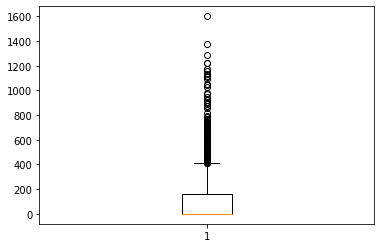

In [ ]:
plt.boxplot(not_miss_MasVnrArea[['MasVnrArea']].toPandas()['MasVnrArea'])

Como podemos observar, esta variable presenta una desviación típica muy alta por lo que ni la media ni la mediana pondrían ser valores representativos para esta variable. Además cuando representamos el boxplot, vemos tiene una gran cantidad de outliers. En consiguiente, creemos adecuado **eliminar** esta variable del estudio.

##### **MasVnrType**

Esta variable representa el **tipo de revestimiento de mampostería**.

Vamos a comenzar estudiando las viviendas a las que le faltan esta variable.

In [ ]:
miss_MasVnrType = data_full_impt.filter(data_full_impt.MasVnrType.isNull())
miss_MasVnrType.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Pensamos que esta variable se podría relacionar con el área de la fachada(**MasVnrArea**), pero al haberla eliminado, creemos adecuado dejar esta variable con el fin de tener una característica que defina el revestimiento de mampostería. Por tanto, vamos a imputar esta variable por la moda con el fin de no alterar la distribución de ésta.

In [ ]:
not_miss_MasVnrType = data_full_impt.filter(data_full_impt.MasVnrType.isNotNull())

In [ ]:
not_miss_MasVnrType.groupby('MasVnrType').count().orderBy(F.desc('count')).show()

+----------+-----+
|MasVnrType|count|
+----------+-----+
|      None| 1742|
|   BrkFace|  879|
|     Stone|  249|
|    BrkCmn|   25|
+----------+-----+



In [ ]:
valimp_MasVnrType = "None"

##### **BsmtFinSF1**

Esta variable representa el **área terminada del sótano del tipo 1 en pies cuadrados**.

Comenzamos investigando la vivienda a la que le falta este dato.

In [ ]:
miss_BsmtFinSF1 = data_full_impt.filter(data_full_impt.BsmtFinSF1.isNull())
miss_BsmtFinSF1.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Si observamos las variables correspondientes al sótano de la vivienda, podemos deducir que no hay sótano. Por tanto, vamos a imputar esta variable por 0 ya que no hay área. 

In [ ]:
valimp_BsmtFinSF1 = 0

##### **BsmtFinSF2**

Esta variable representa el **área terminada del sótano del tipo 2 en pies cuadrados**. 

Comenzamos estudiando la vivienda a la que le falta este dato.

In [ ]:
miss_BsmtFinSF2 = data_full_impt.filter(data_full_impt.BsmtFinSF2.isNull())
miss_BsmtFinSF2.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Observamos que es la misma vivienda que en el caso anterior, es decir, no tiene sótano. Es por ello, por lo que imputamos esta variable por 0.

In [ ]:
valimp_BsmtFinSF2 = 0

##### **BsmtUnfSF**

Esta variable representa el **número de pies cuadrados sin terminar del área del sótano**.

Comenzamos investigando la vivienda a la que le falta este dato.

In [ ]:
miss_BsmtUnfSF = data_full_impt.filter(data_full_impt.BsmtUnfSF.isNull())
miss_BsmtUnfSF.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Podemos observar que esta vivienda corresponde a la de los casos anteriores en las que no había sótano. Es por ello, que vamos a imputar esta variable por 0.

In [ ]:
valimp_BsmtUnfSF = 0

##### **TotalBsmtSF**

Esta variable representa  el **total de pies cuadrados  del área del sótano**.

Vamos a comenzar estudiado la vivienda a la que le falta este dato.

In [ ]:
miss_TotalBsmtSF = data_full_impt.filter(data_full_impt.TotalBsmtSF.isNull())
miss_TotalBsmtSF.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Podemos observar que este es el mismo caso que los anteriores en el que la vivienda no tiene sótano. Por tanto, vamos a imputar esta variable por 0.

In [ ]:
valimp_TotalBsmtSF = 0

##### **Electrical**

Esta variable representa el **sistema eléctrico**. Para imputar esta variable vamos a mirar individuos similares y obtendremos  el valor más frecuente de esta variable.

In [ ]:
miss_Electrical = data_full_impt.filter(data_full_impt.Electrical.isNull())
miss_Electrical.show()
not_miss_Electrical = data_full_impt.filter(data_full_impt.Electrical.isNotNull())

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Nos fijamos en las variables **Heating** (tipo de calefacción), **HeatingQC** (Calidad y condición de la calefacción) y **Central Air** (Aire acondicionado central) que pensamos que pueden guardar relación con el tipo de sistema eléctrico. Por tanto vamos a filtrar los datos no missing de esta variable por cada una de estas tres características y vemos qué tipo de sistema eléctrico es más frecuente.

* Moda de **Electrical** en las viviendas con calefacción del tipo **GasA**.

In [ ]:
not_miss_Electrical.filter(not_miss_Electrical.Heating=='GasA')\
                   .groupby('Electrical').count()\
                   .orderBy(F.desc('count')).show()

+----------+-----+
|Electrical|count|
+----------+-----+
|     SBrkr| 2643|
|     FuseA|  179|
|     FuseF|   42|
|     FuseP|    8|
|       Mix|    1|
+----------+-----+



* Moda de **Electrical** en las viviendas con calidad y condición de la calefacción **Gd**.

In [ ]:
not_miss_Electrical.filter(not_miss_Electrical.HeatingQC == 'Gd')\
                   .groupby('Electrical').count()\
                   .orderBy(F.desc('count')).show()

+----------+-----+
|Electrical|count|
+----------+-----+
|     SBrkr|  420|
|     FuseA|   44|
|     FuseF|    6|
|     FuseP|    2|
|       Mix|    1|
+----------+-----+



* Moda de **Electrical** en las viviendas con **aire acondicionado central**.

In [ ]:
not_miss_Electrical.filter(not_miss_Electrical.CentralAir=='Y')\
                   .groupby('Electrical').count()\
                   .orderBy(F.desc('count')).show()

+----------+-----+
|Electrical|count|
+----------+-----+
|     SBrkr| 2562|
|     FuseA|  138|
|     FuseF|   20|
|       Mix|    1|
|     FuseP|    1|
+----------+-----+



* Moda de **Electrical** en las viviendas con calefacción del tipo **GasA**, cuya calidad y condición de la calefacción es **Gd** y con **aire acondicionado central**.

In [ ]:
indpar_elec = not_miss_Electrical.filter((not_miss_Electrical.HeatingQC=='Gd') \
                                         & (not_miss_Electrical.CentralAir=='Y') \
                                         & (not_miss_Electrical.Heating=='GasA'))
indpar_elec.groupby('Electrical').count().orderBy(F.desc('count')).show()

+----------+-----+
|Electrical|count|
+----------+-----+
|     SBrkr|  401|
|     FuseA|   35|
|     FuseF|    5|
|       Mix|    1|
+----------+-----+



Podemos observar que en todos los casos, la mayoría de viviendas tienen el sistema eléctrico **SBrkr** y además con una diferencia bastante notable. Por tanto, creeamos adecuado imputar esta variable por **SBrkr**.

In [ ]:
valimp_Electrical = 'SBrkr'

##### **BsmtFullBath**

Esta variable representa el **número de baños en el sótano**.

Vamos a investigar las viviendas que no poseen el dato de esta variable.

In [ ]:
miss_BsmtFullBath = data_full_impt.filter(data_full_impt.BsmtFullBath.isNull())

In [ ]:
miss_BsmtFullBath.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Podemos observar que de todas las características con respecto al sótano no tenemos información, eso significa que estas viviendas no tienen sótano. Por tanto, vamos a imputar la variable por 0.

In [ ]:
valimp_BsmtFullBath = 0

##### **BsmtHalfBath**

Esta variable representa el **número medio de baños en el sótano**. 

Comenzamos estudiando las viviendas que no tienen la información de esta variable.


In [ ]:
miss_BsmtHalfBath = data_full_impt.filter(data_full_impt.BsmtHalfBath.isNull())
miss_BsmtHalfBath.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Observamos que estamos en las dos misma viviendas de antes, es decir, no poseen sótano. Por tanto, de la misma forma, vamos a imputar esos dos valores por 0.

In [ ]:
valimp_BsmtHalfBath = 0

##### **KitchenQual**

Esta variable representa la **calidad de la cocina**.

Vamos a comenzar estudiando el caso de la vivienda que no posee este dato.

In [ ]:
miss_KitchenQual = data_full_impt.filter(data_full_impt.KitchenQual.isNull())
miss_KitchenQual.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Podemos observar que esta vivienda es del tipo 50(**MSSubClass**) y tiene solamente una cocina al nivel del suelo(**KitchenAbvGr**). Creemos que esta dos variables pueden estar relacionada con la calidad de la cocina. Por tanto vamos a investigar cómo suelen ser las cocinas de las viviendas del **tipo 50**, y  en concreto, cómo suele ser la **única** cocina al nivel del suelo de las viviendas del tipo 50.

In [ ]:
not_miss_KitchenQual = data_full_impt.filter(data_full_impt.KitchenQual.isNotNull())

* Moda de **KitchenQual** de las viviendas del **tipo 50**.

In [ ]:
not_miss_KitchenQual.filter((not_miss_KitchenQual.MSSubClass==50))\
                            .groupby('KitchenQual').count().show()

+-----------+-----+
|KitchenQual|count|
+-----------+-----+
|         Gd|   57|
|         Ex|    4|
|         Fa|   16|
|         TA|  209|
+-----------+-----+



* Moda **KitchenQual** de las viviendas del **tipo 50** y con **una cocina al nivel del suelo**.

In [ ]:
not_miss_KitchenQual.filter((not_miss_KitchenQual.KitchenAbvGr==1) & \
                            (not_miss_KitchenQual.MSSubClass==50) ) \
                            .groupby('KitchenQual').count().show()

+-----------+-----+
|KitchenQual|count|
+-----------+-----+
|         Gd|   57|
|         Ex|    4|
|         Fa|   16|
|         TA|  206|
+-----------+-----+



En conclusión, la mayoría de las cocinas de las viviendas del **tipo 50** tienen calidad **TA**(medio), y dentro de las que solamente tienen **una cocina** al nivel de suelo, la mayoría tienen la misma calidad. Deducimos entonces que el valor más adecuado para imputar es 'TA'.

In [ ]:
valimp_KitchenQual = 'TA'

##### **Functional**

Esta variable representa el **funcionamiento en el hogar**. Según la descripción de los datos, se supone que es la categoría **Typ** a menos que se justifiquen las deducciones.

In [ ]:
valimp_Functional = "Typ"

##### **GarageYrBlt**

Esta variable representa el **año en el que se construyó el garaje**.

Para imputar esta variable, vamos a investigar las viviendas en las que le falta este dato.

In [ ]:
miss_GarageYrBlt = data_full_impt.filter(data_full_impt.GarageYrBlt.isNull())
miss_GarageYrBlt.show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

A continuación, vamos a estudiar la frecuencia de cada variable relacionada con garaje dentro del conjunto de viviendas con missing en **GarageYrBlt**.

In [ ]:
miss_GarageYrBlt.groupby('GarageType').count().orderBy(F.desc('count')).show()

+----------+-----+
|GarageType|count|
+----------+-----+
|     NotNA|  157|
|    Detchd|    2|
+----------+-----+



In [ ]:
miss_GarageYrBlt.groupby('GarageFinish').count().orderBy(F.desc('count')).show()

+------------+-----+
|GarageFinish|count|
+------------+-----+
|       NotNA|  159|
+------------+-----+



In [ ]:
miss_GarageYrBlt.groupby('GarageCars').count().orderBy(F.desc('count')).show()

+----------+-----+
|GarageCars|count|
+----------+-----+
|         0|  157|
|      null|    1|
|         1|    1|
+----------+-----+



In [ ]:
miss_GarageYrBlt.groupby('GarageArea').count().orderBy(F.desc('count')).show()

+----------+-----+
|GarageArea|count|
+----------+-----+
|         0|  157|
|       360|    1|
|      null|    1|
+----------+-----+



In [ ]:
miss_GarageYrBlt.groupby('GarageCond').count().orderBy(F.desc('count')).show()

+----------+-----+
|GarageCond|count|
+----------+-----+
|     NotNA|  159|
+----------+-----+



De aquí podemos decir que hay **157** viviendas que no tienen garaje ya que todas las características del garaje vienen como valor **NotNA**(No Garaje) o **0** en el caso de **GarageArea** y **GarageCars**. Sin embargo, observamos que hay dos viviendas que si tienen garaje, ya que el valor en **GarageType** es igual a **Detchd**, es decir, el garaje se encuentra fuera de la vivienda. Vamos a investigar estos casos un poco más.

In [ ]:
miss_GarageYrBlt.filter(miss_GarageYrBlt.GarageType=='Detchd').show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Podemos observar que una de ellas tiene una capacidad para un coche y 360 de área y sin embargo de la otra no sabemos más información, porlo que suponemos que no se ha construido aún el garaje.

Por tanto, vamos a imputar a los que no tienen garaje por la moda de la variable con el fin de no distorsionar la distribución de ésta. Y por otro lado, vamos a imputar estos dos casos por el año más repetido dentro de las viviendas con garaje externo.

In [ ]:
not_miss_GarageYrBlt = data_full_impt.filter(data_full_impt.GarageYrBlt.isNotNull())

In [ ]:
not_miss_GarageYrBlt.groupby('GarageYrBlt').count().orderBy(F.desc('count')).show()

+-----------+-----+
|GarageYrBlt|count|
+-----------+-----+
|       2005|  142|
|       2006|  115|
|       2007|  115|
|       2004|   99|
|       2003|   92|
|       1977|   66|
|       2008|   61|
|       1998|   58|
|       2000|   55|
|       1999|   54|
|       2002|   53|
|       1950|   51|
|       1976|   50|
|       1993|   49|
|       1968|   48|
|       1997|   44|
|       1958|   42|
|       2001|   41|
|       1978|   41|
|       1956|   41|
+-----------+-----+
only showing top 20 rows



In [ ]:
valimp_GarageYrBlt = 2005

Vamos a sacar ahora la **moda** dentro de las viviendas con **garaje externo**.

In [ ]:
not_miss_GarageYrBlt.filter(not_miss_GarageYrBlt.GarageType=='Detchd').groupby('GarageYrBlt').count().orderBy(F.desc('count')).show()

+-----------+-----+
|GarageYrBlt|count|
+-----------+-----+
|       1950|   29|
|       1920|   27|
|       1930|   24|
|       1940|   18|
|       1939|   18|
|       1977|   17|
|       1999|   17|
|       1973|   16|
|       1979|   16|
|       2004|   16|
|       1962|   15|
|       1926|   15|
|       2000|   13|
|       1925|   13|
|       1980|   13|
|       1974|   13|
|       1972|   12|
|       1948|   12|
|       1965|   11|
|       2005|   11|
+-----------+-----+
only showing top 20 rows



Por tanto vamos a imputar esos dos casos por **1950**, aunque se podría tambien imputar por 1920 y más adelante imputaremos los casos de viviendas que no tenían garaje.

In [ ]:
data_full_impt = data_full_impt.withColumn('GarageYrBlt',\
                 when((data_full_impt.GarageYrBlt.isNull()) & \
                      (data_full_impt.GarageType=='Detchd'),1950) \
                      .otherwise(data_full_impt.GarageYrBlt))

Comprobamos que esos dos casos no aparecen si filtramos por los valores nulos de **GarageYrBlt** cuyo garaje es de tipo externo.

In [ ]:
data_full_impt.filter((data_full_impt.GarageYrBlt.isNull()) & \
                      (data_full_impt.GarageType=='Detchd')).show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

##### **GarageCars**

Esta variable representa el **número de coches que cabe en el garaje**.

Vamos a comenzar investigando la vivienda que le falta esta información.

In [ ]:
miss_GarageCars = data_full_impt.filter(data_full_impt.GarageCars.isNull())
miss_GarageCars.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Podemos observar que estamos ante un caso en el que se sabe cuál va a ser el tipo de garaje pero aún no se ha construido. Es por ello que no sabemos nada del resto de variables relacionadas con el garaje.

Podríamos investigar el resto de viviendas que tienen el garaje fuera de la casa e imputar por el número más frecuente de coches que caben en él.

In [ ]:
not_miss_GarageCars = data_full_impt.filter(data_full_impt.GarageCars.isNotNull())

In [ ]:
not_miss_GarageCars.filter(not_miss_GarageCars.GarageType=='Detchd') \
                   .groupby('GarageCars').count().show()

+----------+-----+
|GarageCars|count|
+----------+-----+
|         1|  376|
|         3|   13|
|         5|    1|
|         4|    4|
|         2|  384|
+----------+-----+



Por tanto, vamos a imputar por 2 coches que cabrían, pero se podría imputar por 1 ya que no tenemos más información y también es muy frecuente en los garajes fuera de la vivienda.

In [ ]:
valimp_GarageCars = 2

##### **GarageArea**

Esta variable representa el **área del garaje**.

Vamos a comenzar investigando la vivienda que le falta esta información.

In [ ]:
miss_GarageArea = data_full_impt.filter(data_full_impt.GarageArea.isNull())
miss_GarageArea.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Este sigue siendo el mismo caso anterior en el que no está construido el garaje todavía. Por ello, vamos a filtrar por los garajes fuera de casa y veamos si es más adecuado imputar por la media o la mediana.

In [ ]:
not_miss_GarageArea = data_full_impt.filter(data_full_impt.GarageArea.isNotNull())

In [ ]:
not_miss_GarageArea_detchd = not_miss_GarageArea.filter(not_miss_GarageArea.GarageType=="Detchd")

* Calculamos la **media** de **GarageArea** dentro de las viviendas con garaje externo.

In [ ]:
not_miss_GarageArea_detchd.agg({'GarageArea':'avg'}).show()

+------------------+
|   avg(GarageArea)|
+------------------+
|419.49228791773777|
+------------------+



* Calculamos la **mediana** de **GarageArea** dentro de las viviendas con garaje externo.

In [ ]:
statFunc(not_miss_GarageArea_detchd).approxQuantile('GarageArea', [0.5], 0.1)

[360.0]

* Calculamos un **resumen numérico** de **GarageArea** dentro de las viviendas con garaje externo.

In [ ]:
not_miss_GarageArea_detchd.describe('GarageArea').show()

+-------+------------------+
|summary|        GarageArea|
+-------+------------------+
|  count|               778|
|   mean|419.49228791773777|
| stddev|174.72657239619394|
|    min|               100|
|    max|              1488|
+-------+------------------+



Al haber mucha variabilidad en el área de los garajes externos, creemos más adecuado utilizar la **mediana**.

In [ ]:
valimp_GarageArea = 360

##### **SaleType**

Esta variable representa el **tipo de venta**. 

Comenzamos estudiando la vivienda que le falta este dato.

In [ ]:
miss_SaleType = data_full_impt.filter(data_full_impt.SaleType.isNull())
miss_SaleType.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Conditi

Podemos relacionar el tipo de venta(**SaleType**) con la condición(**SaleCondition**) de ésta e investigar cuál es el tipo de venta más frecuente.

In [ ]:
not_miss_SaleType= data_full_impt.filter(data_full_impt.SaleType.isNotNull())

In [ ]:
not_miss_SaleType.filter(not_miss_SaleType.SaleCondition=='Normal') \
                  .groupby('SaleType').count() \
                  .orderBy(F.desc('count')).show()

+--------+-----+
|SaleType|count|
+--------+-----+
|      WD| 2314|
|     COD|   39|
|   ConLD|   21|
|     CWD|   10|
|   ConLw|    7|
|   ConLI|    5|
|     Con|    4|
|     Oth|    1|
+--------+-----+



Calculamos ahora la **distribución** de esta variable en aquellas viviendas donde no hay missing.

In [ ]:
not_miss_SaleType.groupby('SaleType').count().orderBy(F.desc('count')).show()

+--------+-----+
|SaleType|count|
+--------+-----+
|      WD| 2525|
|     New|  239|
|     COD|   87|
|   ConLD|   26|
|     CWD|   12|
|   ConLI|    9|
|   ConLw|    8|
|     Oth|    7|
|     Con|    5|
+--------+-----+



Observamos que la distribución de esta variable se concentra en el tipo **WD**. Además al relacionar la condición de venta con el tipo, obtenemos la misma concentración en **WD**. En consecuencia, tiene sentido que imputemos por este valor.

In [ ]:
valimp_SaleType = 'WD'

#### **Imputación de los valores missing**


Una vez estudiada el valor a imputar de cada variable con valores faltantes, vamos a proceder a la **imputación** de dichos datos.

In [ ]:
#Eliminamos, tanto del conjunto de datos completo como de la lista de variables 
#numéricas, las variables "LotFrontage" y "MasVnrArea".

data_full2= data_full_impt.drop("LotFrontage", "MasVnrArea")
vars_numericas.remove('LotFrontage')
vars_numericas.remove('MasVnrArea')

data_imputed = data_full2.fillna({'MSZoning': valimp_MSZoning,
                                  'Utilities': valimp_Utilities,
                                  'Exterior1st': valimp_Exterior1st,
                                  'Exterior2nd': valimp_Exterior2nd,
                                  'MasVnrType': valimp_MasVnrType,
                                  'BsmtFinSF1': valimp_BsmtFinSF1,
                                  'BsmtFinSF2': valimp_BsmtFinSF2,
                                  'BsmtUnfSF': valimp_BsmtUnfSF,
                                  'TotalBsmtSF': valimp_TotalBsmtSF,
                                  'Electrical': valimp_Electrical,
                                  'BsmtFullBath': valimp_BsmtFullBath,
                                  'BsmtHalfBath': valimp_BsmtHalfBath,
                                  'KitchenQual': valimp_KitchenQual,
                                  'Functional': valimp_Functional,
                                  'GarageYrBlt': valimp_GarageYrBlt,
                                  'GarageCars': valimp_GarageCars,
                                  'GarageArea': valimp_GarageArea,
                                  'SaleType': valimp_SaleType})

Vamos a comprobar que no hay ninguna variable con valores faltantes excepto **SalePrice**.

In [ ]:
# Definimos la operación para cada columna del DF.
exprs = [count_nulls(c) for c in data_imputed.columns]

# Aplicamos todas las operaciones.
data_imputed.agg(*exprs).show()

+---+----------+--------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType|HouseStyle|OverallQual|O

Por último vamos a volver a separar los datos en **entrenamiento** y **test**.

In [ ]:
data_train_final = data_imputed.filter(data_imputed.SalePrice.isNotNull())
data_test_final = data_imputed.filter(data_imputed.SalePrice.isNull())

### Estudio variable respuesta SalePrice

A continuación, vamos a estudiar la variable respuesta **SalePrice**.

In [ ]:
data_train_final.describe("SalePrice").show()

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1460|
|   mean|180921.19589041095|
| stddev| 79442.50288288663|
|    min|             34900|
|    max|            755000|
+-------+------------------+



Podemos observar que tenemos 1460 valores con un valor medio de aproximadamente 180921 y una desviación típica de 79442.5. El valor mínimo de la variable se da en 34900, mientras que el valor máximo que toma es de 755000.


 mu = 180921.20 and sigma = 79415.29



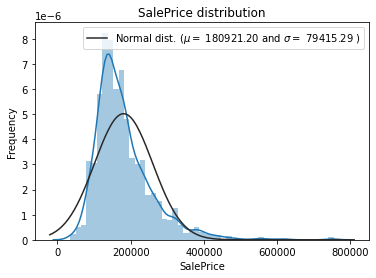

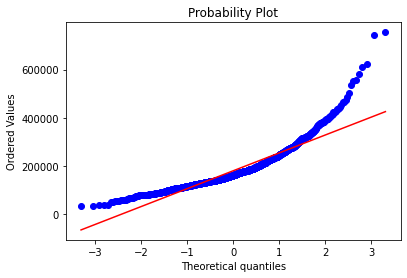

Skewness: 1.882876
Kurtosis: 6.536282


In [ ]:
df_saleprice = data_train_final.select("SalePrice").toPandas()
sns.distplot(df_saleprice['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(df_saleprice['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_saleprice['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % df_saleprice['SalePrice'].skew())
print("Kurtosis: %f" % df_saleprice['SalePrice'].kurt())

Podemos observar en la primera gráfica que aunque el rango de valores que toma es muy grande, la mayoría de las viviendas se concentra en un precio entre 10000 y 20000. Es decir, vemos que la variable **SalePrice** es asimétrica o sesgada a la derecha y además tiene una distribución leptocúrtica(curtosis>0).
Por otro lado, en la segunda gráfica podemos observar que la variable no sigue una normal ya que los cuantiles teóricos no coinciden con los estimados. Por tanto, a continuación, vamos hacer una transformación de la variable con el fin de conseguir una distribución normal simétrica.

In [ ]:
data_train_final_2 = data_train_final.withColumn('logSalePrice',log(data_train_final.SalePrice))


 mu = 12.02 and sigma = 0.40



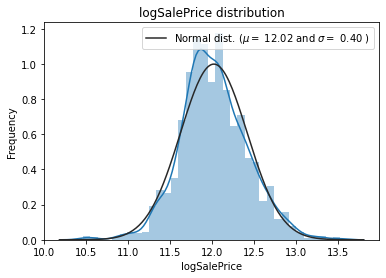

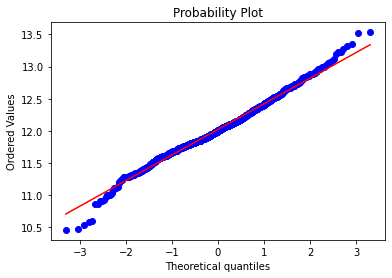

Skewness: 0.121335
Kurtosis: 0.809532


In [ ]:
df_logsaleprice = data_train_final_2.select("logSalePrice").toPandas()
sns.distplot(df_logsaleprice['logSalePrice'], fit=norm)

(mu, sigma) = norm.fit(df_logsaleprice['logSalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('logSalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_logsaleprice['logSalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % df_logsaleprice['logSalePrice'].skew())
print("Kurtosis: %f" % df_logsaleprice['logSalePrice'].kurt())


Observamos que, al aplicar la transformación del logaritmo, la distribución se vuelve normal y simétrica. Por tanto, a partir de ahora, nuestra variable respuesta en los modelos será **logSalePrice**.

Añadimos esta nueva variable al conjunto **test**.

In [ ]:
data_test_final_2=data_test_final.withColumn('logSalePrice',F.lit(None).cast(IntegerType()))

### Conversión de variables categóricas

A continuación, vamos a convertir las variables categóricas a numéricas para utilizarlas en los modelos basados en árboles y a onehot para todos los modelos.

In [ ]:
cols_to_index = vars_categoricas
cols_to_onehot = vars_categoricas 
cols_num = vars_numericas[:-1]

#### StringIndexer

In [ ]:
pipeline_stages = []
idx_cols = []
for col in cols_to_index:
    idx_col = col+'_idx'
    idx_cols.append(idx_col)
    pipeline_stages.append(StringIndexer(inputCol=col, outputCol=idx_col))

#### OneHotEncoder

In [ ]:
ohe_inputCols = []
ohe_outputCols = []
for col in cols_to_onehot:
    ohe_inputCols.append(col+'_idx')
    ohe_outputCols.append(col+'_vec')
    
pipeline_stages.append(OneHotEncoderEstimator(inputCols=ohe_inputCols, outputCols=ohe_outputCols))

#### VectorAssembler

In [ ]:
#En raw_cols vamos a guardar las variables numéricas y las variables categóricas 
#convertidas a numéricas

raw_cols = []
raw_cols.extend(cols_num)
raw_cols.extend(idx_cols)

#En final_cols nos vamos a guardar las variables numéricas y las variables onehot

final_cols = []
final_cols.extend(cols_num)
final_cols.extend(ohe_outputCols)
print(final_cols)


pipeline_stages.append(VectorAssembler(inputCols=final_cols, outputCol='features_ohe'))
pipeline_stages.append(VectorAssembler(inputCols=raw_cols, outputCol='features_raw'))

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_vec', 'Street_vec', 'Alley_vec', 'LotShape_vec', 'LandContour_vec', 'Utilities_vec', 'LotConfig_vec', 'LandSlope_vec', 'Neighborhood_vec', 'Condition1_vec', 'Condition2_vec', 'BldgType_vec', 'HouseStyle_vec', 'RoofStyle_vec', 'RoofMatl_vec', 'Exterior1st_vec', 'Exterior2nd_vec', 'MasVnrType_vec', 'ExterQual_vec', 'ExterCond_vec', 'Foundation_vec', 'BsmtQual_vec', 'BsmtCond_vec', 'BsmtExposure_vec', 'BsmtFinType1_vec', 'BsmtFinType2_vec', 'Heating_vec', 'HeatingQC_vec', 'CentralAir_vec', 'Electrical_vec', 'Kitchen

#### Pipeline

In [ ]:
#Como anteriormente hemos añadido la variable logSalePrice,
#volvemos a unir el train con el test.
data_full_final = data_train_final_2.union(data_test_final_2)

pipeline = Pipeline(stages=pipeline_stages)
pipeline_model = pipeline.fit(data_full_final)
data_full_final2 = pipeline_model.transform(data_full_final)
data_full_final2.show(3)

+---+----------+--------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+------------------+------------+----------+---------+------------+---------------+-------------+-------------+-------------+----------------+--------------+----------

Vamos ahora a dividir el conjunto ***data_full_final2*** en **train** y **test** ya que el escalado lo haremos aprendiendo a partir del **train**.

In [ ]:
data_train_def =  data_full_final2.filter(data_full_final2.logSalePrice.isNotNull())
data_train_def.show(1)

data_train_ohe = data_train_def.select(F.col('Id'),F.col('features_ohe'), F.col('features_raw'), F.col('logSalePrice').alias('label'))
data_train_ohe.show(3)
data_train_ohe.count()

+---+----------+--------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+------------------+------------+----------+---------+------------+---------------+-------------+-------------+-------------+----------------+--------------+----------

1460

In [ ]:
data_test_def =  data_full_final2.filter(data_full_final2.logSalePrice.isNull())
data_test_def.show(1)

data_test_ohe = data_test_def.select(F.col('Id'),F.col('features_ohe'), F.col('features_raw'), F.col('logSalePrice').alias('label'))
data_test_ohe.show(3)

+----+----------+--------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+------------+------------+----------+---------+------------+---------------+-------------+-------------+-------------+----------------+--------------+--------------+

#### Escalado - MaxAbsEscaler

A continuación, vamos a escalar los datos aprendiendo del conjunto **train**. Por un lado **escalaremos** las variables **numéricas** con las de **stringIndexer** y por otro lado las variables **numéricas** con las **one hot**.

In [ ]:
maxabs_scaler1 = MaxAbsScaler(inputCol='features_ohe', outputCol='features_ohe_esc')
maxabs_scaler2 = MaxAbsScaler(inputCol='features_raw', outputCol='features_esc')
pipeline_scaler1 = Pipeline(stages=[maxabs_scaler1])
pipeline_scaler2 = Pipeline(stages=[maxabs_scaler2])
maxabs_scaler_model1 = pipeline_scaler1.fit(data_train_ohe)
maxabs_scaler_model2 = pipeline_scaler2.fit(data_train_ohe)
data_train_ohe_esc_maxabs = maxabs_scaler_model1.transform(data_train_ohe)
data_train_ohe_esc_maxabs = maxabs_scaler_model2.transform(data_train_ohe_esc_maxabs)
data_train_ohe_esc_maxabs.show(3)

+---+--------------------+--------------------+------------------+--------------------+--------------------+
| Id|        features_ohe|        features_raw|             label|    features_ohe_esc|        features_esc|
+---+--------------------+--------------------+------------------+--------------------+--------------------+
|  1|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|12.247694320220994|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|
|  2|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|12.109010932687042|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|
|  3|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...| 12.31716669303576|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|
+---+--------------------+--------------------+------------------+--------------------+--------------------+
only showing top 3 rows



**Escalamos** ahora el conjunto **test** con lo aprendido sobre el conjunto **train**.

In [ ]:
data_test_ohe_esc = maxabs_scaler_model1.transform(data_test_ohe)
data_test_ohe_esc = maxabs_scaler_model2.transform(data_test_ohe_esc)
data_test_ohe_esc.show(3)

+----+--------------------+--------------------+-----+--------------------+--------------------+
|  Id|        features_ohe|        features_raw|label|    features_ohe_esc|        features_esc|
+----+--------------------+--------------------+-----+--------------------+--------------------+
|1461|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...| null|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|
|1462|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...| null|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|
|1463|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...| null|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|
+----+--------------------+--------------------+-----+--------------------+--------------------+
only showing top 3 rows



## Reducción de la dimensionalidad y ajuste de modelos

Vamos a comenzar dividiendo el conjunto de **entrenamiento** ya procesado en un subconjunto para **entrenar** el modelo y otro para **evaluarlo**.

In [ ]:
train, valid = data_train_ohe_esc_maxabs.randomSplit([0.8, 0.2], seed=global_seed) 
print('Tamaño train: {}. Tamaño valid: {}.'.format(train.count(), valid.count()))
print(train.first())
print(valid.first())

Tamaño train: 1181. Tamaño valid: 279.
Row(Id=1, features_ohe=SparseVector(257, {0: 60.0, 1: 8450.0, 2: 7.0, 3: 5.0, 4: 2003.0, 5: 2003.0, 6: 706.0, 8: 150.0, 9: 856.0, 10: 856.0, 11: 854.0, 13: 1710.0, 14: 1.0, 16: 2.0, 17: 1.0, 18: 3.0, 19: 1.0, 20: 8.0, 22: 2003.0, 23: 2.0, 24: 548.0, 26: 61.0, 32: 2.0, 33: 2008.0, 34: 1.0, 38: 1.0, 39: 1.0, 41: 1.0, 44: 1.0, 47: 1.0, 48: 1.0, 52: 1.0, 55: 1.0, 78: 1.0, 86: 1.0, 93: 1.0, 98: 1.0, 104: 1.0, 109: 1.0, 116: 1.0, 130: 1.0, 146: 1.0, 149: 1.0, 151: 1.0, 155: 1.0, 161: 1.0, 164: 1.0, 168: 1.0, 173: 1.0, 178: 1.0, 184: 1.0, 189: 1.0, 193: 1.0, 194: 1.0, 199: 1.0, 201: 1.0, 207: 1.0, 212: 1.0, 219: 1.0, 221: 1.0, 226: 1.0, 231: 1.0, 233: 1.0, 236: 1.0, 240: 1.0, 244: 1.0, 252: 1.0}), features_raw=SparseVector(77, {0: 60.0, 1: 8450.0, 2: 7.0, 3: 5.0, 4: 2003.0, 5: 2003.0, 6: 706.0, 8: 150.0, 9: 856.0, 10: 856.0, 11: 854.0, 13: 1710.0, 14: 1.0, 16: 2.0, 17: 1.0, 18: 3.0, 19: 1.0, 20: 8.0, 22: 2003.0, 23: 2.0, 24: 548.0, 26: 61.0, 32: 2.0, 33:

Recordemos que la variable respuesta que vamos a utilizar en los modelos va a ser la **transformación logaritmo de SalePrice**, por lo que si queremos la predicción real tendríamos que aplicarle la exponencial a la predicción obtenida.

### Correlación variables numéricas

Vamos ahora a calcular la correlación entre las variables numéricas. Al utilizarse feature, que contiene todas las variables tanto numéricas como categóricas, la correlación se calculará para todas ellas pero debemos tener en cuenta que la correlación de pearson para las categóricas no tiene sentido.

In [ ]:
mat_corr=Correlation.corr(train,column='features_esc', method='pearson')

In [ ]:
rows=mat_corr.collect()[0][0].toArray()
cols=cols_num+idx_cols
df = pd.DataFrame(rows,columns=cols,index=cols)

#Nos quedamos con la correlación entre las variables numéricas
mat_corr_numericas = df.loc[cols_num,cols_num]
mat_corr_numericas

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.183489,0.030132,-0.054183,0.028087,0.053411,-0.065408,-0.084226,-0.144369,-0.245352,-0.259736,0.311060,0.061668,0.073395,-0.016848,0.004898,0.133436,0.177200,-0.028956,0.280439,0.028215,-0.062174,0.106808,-0.050525,-0.113738,-0.040913,0.001349,-0.007957,-0.039474,-0.011521,0.009348,-0.040167,-0.016628,-0.019675
LotArea,-0.183489,1.000000,0.121985,-0.007539,0.004330,0.019271,0.222465,0.121791,-0.004751,0.270730,0.308075,0.057583,0.013322,0.274163,0.150417,0.066553,0.116578,0.019360,0.120181,-0.020199,0.192659,0.278029,-0.049329,0.152238,0.178909,0.138051,0.106834,-0.018471,0.015961,0.047519,0.087353,0.021378,-0.003757,-0.012963
OverallQual,0.030132,0.121985,1.000000,-0.118486,0.565505,0.542853,0.215496,-0.066690,0.326050,0.528536,0.475785,0.295685,-0.032276,0.589599,0.094754,-0.025887,0.541425,0.275667,0.093406,-0.177425,0.435941,0.394535,0.434616,0.611923,0.561984,0.224039,0.320467,-0.123533,0.031434,0.066966,0.074199,-0.018472,0.036753,-0.029694
OverallCond,-0.054183,-0.007539,-0.118486,1.000000,-0.400952,0.043331,-0.051927,0.052265,-0.145936,-0.182147,-0.141649,0.019693,0.037491,-0.083738,-0.052393,0.086898,-0.207498,-0.064632,0.019633,-0.060892,-0.066645,-0.042358,-0.289945,-0.212157,-0.172343,0.001062,-0.020270,0.061688,0.011799,0.062978,-0.002561,0.101320,-0.006036,0.050366
YearBuilt,0.028087,0.004330,0.565505,-0.400952,1.000000,0.605953,0.227673,-0.053640,0.158794,0.376501,0.273392,0.000929,-0.185403,0.183229,0.170685,-0.033255,0.458942,0.229740,-0.085733,-0.189329,0.089127,0.121964,0.714139,0.541097,0.469614,0.214262,0.188937,-0.398618,0.036748,-0.045140,0.004841,-0.039142,-0.000639,-0.011853
YearRemodAdd,0.053411,0.019271,0.542853,0.043331,0.605953,1.000000,0.114304,-0.068540,0.181698,0.276863,0.229449,0.127906,-0.040872,0.269798,0.115321,-0.014903,0.434400,0.180293,-0.053086,-0.140278,0.182047,0.089584,0.581723,0.426901,0.368165,0.202523,0.229601,-0.207512,0.040842,-0.026138,0.006659,0.004719,-0.008291,0.039069
BsmtFinSF1,-0.065408,0.222465,0.215496,-0.051927,0.227673,0.114304,1.000000,-0.047346,-0.493915,0.516490,0.436328,-0.118446,-0.057317,0.215574,0.640972,0.080863,0.045822,0.012696,-0.088958,-0.089122,0.060808,0.240306,0.109108,0.198674,0.267142,0.166971,0.129339,-0.084380,0.032073,0.079878,0.156740,0.002968,-0.005341,0.026332
BsmtFinSF2,-0.084226,0.121791,-0.066690,0.052265,-0.053640,-0.068540,-0.047346,1.000000,-0.217208,0.103418,0.097749,-0.097216,0.023206,-0.006829,0.168421,0.046768,-0.074064,-0.055117,-0.020662,-0.054780,-0.038539,0.061133,-0.093831,-0.033861,-0.017182,0.089186,-0.020763,0.022050,-0.034934,0.063885,0.044838,-0.006925,-0.012575,0.052344
BsmtUnfSF,-0.144369,-0.004751,0.326050,-0.145936,0.158794,0.181698,-0.493915,-0.217208,1.000000,0.421443,0.329230,-0.018071,0.020871,0.227711,-0.416464,-0.091642,0.290940,-0.056387,0.137941,0.043442,0.237151,0.062677,0.171360,0.229536,0.198525,0.003919,0.124689,-0.005835,0.011685,-0.014196,-0.038916,-0.019807,0.015560,-0.052237
TotalBsmtSF,-0.245352,0.270730,0.528536,-0.182147,0.376501,0.276863,0.516490,0.103418,0.421443,1.000000,0.821500,-0.177079,-0.029508,0.451261,0.303885,0.008218,0.314654,-0.064539,0.040050,-0.068593,0.288885,0.334923,0.251590,0.425555,0.471183,0.209953,0.252445,-0.085003,0.032012,0.092059,0.139439,-0.019581,0.005557,-0.006193


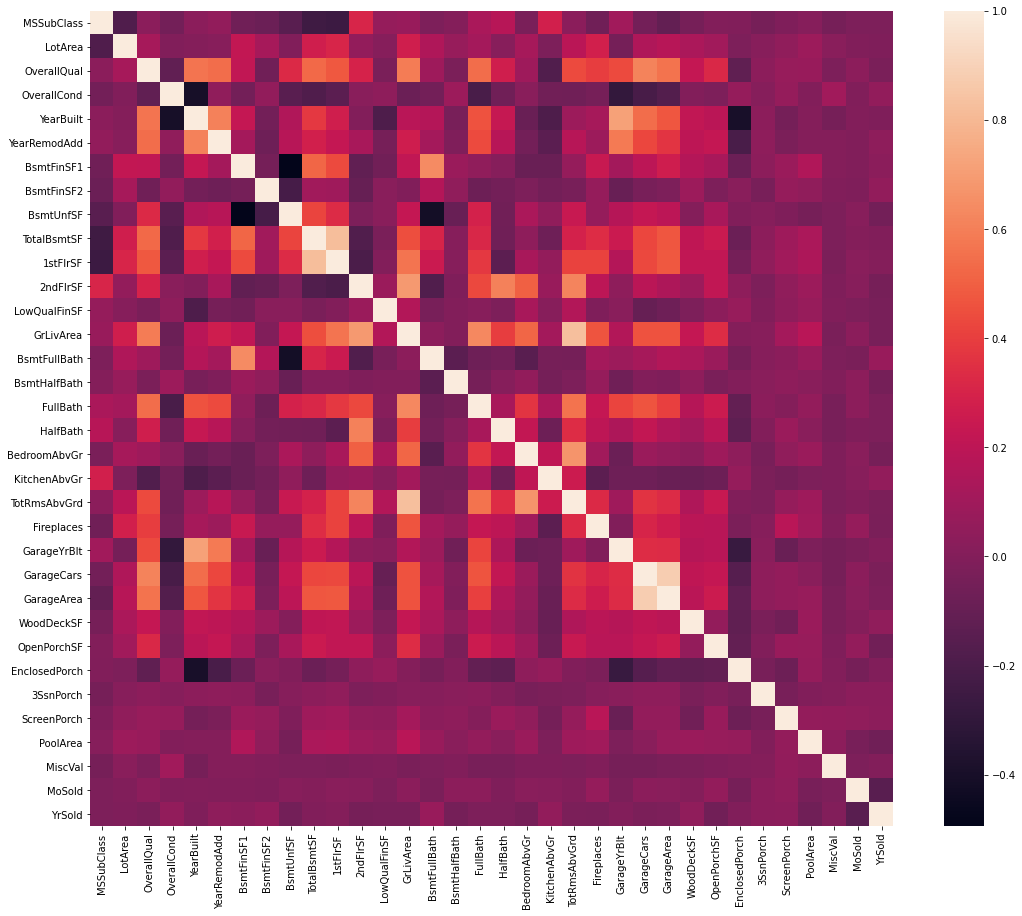

In [ ]:
f, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(mat_corr_numericas)

Como podemos observar hay zonas muy claras, por lo que existen variables fuertemente correladas positivamente, como por ejemplo es el caso de **TotalBsmtSF** y **1stFlrSF** o **GarageArea** y **GarageCars**. Por otro lado, observamos zonas muy oscuras, lo que significa que hay variables fuertemente correladas negativamente, como es el caso de **EnclosedPorch** y **YearBuilt**. Por tanto, estamos ante un problema de multicolinealidad y en consecuencia, tiene sentido aplicar un análisis de componentes principales.

### PCA: Análisis de componentes principales

A continuación, vamos a realizar un análisis de componentes principales sobre el conjunto de entrenamiento **train**, con el fin de reducir la dimensionalidad. Comenzaremos haciéndola con k igual al número de variables y determinaremos el número de componentes principales mediante la varianza explicada por cada componente.

* Para el **feauture_esc**




In [ ]:
pca_todas_raw = PCA(k=77,inputCol='features_esc',outputCol='pca_features_raw_esc')

In [ ]:
model_pca_todas_raw=pca_todas_raw.fit(train)

Construimos un dataframe para representar la varianza explicada y la  acumulada.

In [ ]:
nombres=['Componente Principal '+ str(k) for k in range(1,len(cols_num)+len(idx_cols)+1)]
var_expl=model_pca_todas_raw.explainedVariance
import pandas as pd
df_pca=pd.DataFrame(columns=['Componente principal','Varianza explicada',
                             'Varianza explicada acumulada'])
df_pca['Componente principal']=nombres
df_pca['Varianza explicada']=var_expl
df_pca['Varianza explicada acumulada']=df_pca['Varianza explicada'].cumsum()
df_pca.head(26)

,Componente principal,Varianza explicada,Varianza explicada acumulada
0,Componente Principal 1,0.130585,0.130585
1,Componente Principal 2,0.070264,0.200849
2,Componente Principal 3,0.066946,0.267794
3,Componente Principal 4,0.057883,0.325678
4,Componente Principal 5,0.046235,0.371912
5,Componente Principal 6,0.041302,0.413214
6,Componente Principal 7,0.037969,0.451183
7,Componente Principal 8,0.031469,0.482652
8,Componente Principal 9,0.027974,0.510626
9,Componente Principal 10,0.026572,0.537198


Nos vamos a quedar con aquellas componentes principales que expliquen un 80% de la variabilidad explicada acumulada. En este caso podemos observar que con 25 componentes principales ya se obtiene.

* Para el **feature_ohe_esc**: En este caso como no sabemos cuántas variables hay en total, vamos a ir modificando el parámetro k hasta que podamos ver cuándo se obtiene alrededor de un 80% de la variabilidad explicada.



In [ ]:
pca_ohe_pb = PCA(k=50,inputCol='features_ohe_esc',outputCol='pca_features_ohe_esc')

In [ ]:
model_pca_ohe_pb=pca_ohe_pb.fit(train)

Construimos un dataframe para representar la varianza explicada y acumulada.

In [ ]:
nombres_ohe=['Componente Principal '+ str(k) for k in range(1,51)]
var_expl=model_pca_ohe_pb.explainedVariance
df_pca=pd.DataFrame(columns=['Componente principal','Varianza explicada',
                             'Varianza explicada acumulada'])
df_pca['Componente principal']=nombres_ohe
df_pca['Varianza explicada']=var_expl
df_pca['Varianza explicada acumulada']=df_pca['Varianza explicada'].cumsum()
df_pca.head(45)

,Componente principal,Varianza explicada,Varianza explicada acumulada
0,Componente Principal 1,0.145776,0.145776
1,Componente Principal 2,0.060083,0.205859
2,Componente Principal 3,0.038473,0.244332
3,Componente Principal 4,0.035847,0.280179
4,Componente Principal 5,0.032712,0.312891
5,Componente Principal 6,0.027698,0.340590
6,Componente Principal 7,0.026423,0.367013
7,Componente Principal 8,0.023274,0.390287
8,Componente Principal 9,0.021032,0.411319
9,Componente Principal 10,0.020656,0.431975


Podemos observar que con 44 componentes principales se obtiene un 80% de la variabilidad explicada.

Una vez que hemos decidido con cuántas componentes principales nos vamos a quedar en cada caso, vamos a montar un pipeline para automatizar los procesos.

In [ ]:
pca_raw = PCA(k=25,inputCol='features_esc',outputCol='pca_features_raw_esc')
pca_ohe = PCA(k=44,inputCol='features_ohe_esc',outputCol='pca_features_ohe_esc')
pipeline_pca = Pipeline(stages=[pca_raw,pca_ohe])
model_pca = pipeline_pca.fit(train)

In [ ]:
train_pca = model_pca.transform(train)
train_pca.show(2)

+---+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
| Id|        features_ohe|        features_raw|             label|    features_ohe_esc|        features_esc|pca_features_raw_esc|pca_features_ohe_esc|
+---+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|  1|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|12.247694320220994|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|[-1.1999303283311...|[-2.6965894834728...|
|  2|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|12.109010932687042|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|[-0.8701377574017...|[-0.3331800054289...|
+---+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



Transformamos el conjunto de **validación** y el conjunto **test** con lo aprendido en el **train**.

In [ ]:
valid_pca = model_pca.transform(valid)
valid_pca.show(2)

+---+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
| Id|        features_ohe|        features_raw|             label|    features_ohe_esc|        features_esc|pca_features_raw_esc|pca_features_ohe_esc|
+---+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|  5|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|12.429216196844383|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|[-1.6565853306980...|[-3.1932218232872...|
| 10|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|11.678439903447801|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|[-0.4820199714037...|[0.05015382182514...|
+---+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
test_pca = model_pca.transform(data_test_ohe_esc)
test_pca.show(2)

+----+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  Id|        features_ohe|        features_raw|label|    features_ohe_esc|        features_esc|pca_features_raw_esc|pca_features_ohe_esc|
+----+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|1461|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...| null|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|[-0.1708538296775...|[0.91640459245183...|
|1462|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...| null|(257,[0,1,2,3,4,5...|(77,[0,1,2,3,4,5,...|[-0.6067441677346...|[0.32005059049221...|
+----+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



### Selección de variables

A continuación, vamos a seleccionar aquellas componentes principales que guardan relación con la variable respuesta **logSalePrice**. Para ello, utilizaremos la importancia de variables que nos da el **random forest**. Por tanto, vamos a construir dos modelos random forest, uno para raw y otro para one hot realizando previamente un ajuste de hiperparámetros mediante una validación cruzada con 5 pliegues.

In [ ]:
rf_raw_sv = RandomForestRegressor(featuresCol='pca_features_raw_esc', predictionCol='pred_rf_raw_esc_sv', seed=global_seed)
rf_ohe_sv = RandomForestRegressor(featuresCol='pca_features_ohe_esc', predictionCol='pred_rf_ohe_esc_sv', seed=global_seed)

Definimos las **rejillas** de parámetros que vamos a utilizar.

In [ ]:
print(rf_raw_sv.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
paramGrid_raw_sv = ParamGridBuilder() \
    .addGrid(rf_raw_sv.maxDepth, [4, 5, 7]) \
    .addGrid(rf_raw_sv.numTrees, [10, 25, 50]) \
    .build()

paramGrid_ohe_sv = ParamGridBuilder() \
    .addGrid(rf_ohe_sv.maxDepth, [4, 5, 7]) \
    .addGrid(rf_ohe_sv.numTrees, [10, 25, 50]) \
    .build()
    
len(paramGrid_raw_sv)
len(paramGrid_ohe_sv)

9

Creamos ahora los objetos para la **validación cruzada**.

In [ ]:
crossval_rf_raw_sv = CrossValidator(estimator=rf_raw_sv,
                          estimatorParamMaps=paramGrid_raw_sv,
                          evaluator=RegressionEvaluator(predictionCol='pred_rf_raw_esc_sv',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed)

crossval_rf_ohe_sv = CrossValidator(estimator=rf_ohe_sv,
                          estimatorParamMaps=paramGrid_ohe_sv,
                          evaluator=RegressionEvaluator(predictionCol='pred_rf_ohe_esc_sv',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed) 

Vamos a realizar el **ajuste de hiperparámetros** para ambos conjuntos de datos.

In [ ]:
t0 = time()
rf_raw_sv_cv_model = crossval_rf_raw_sv.fit(train_pca)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 124.6 sec.


In [ ]:
t0 = time()
rf_ohe_sv_cv_model = crossval_rf_ohe_sv.fit(train_pca)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 123.46 sec.


Obtenemos el **mejor** modelo entrenado con sus hiperparámetros.
* **rf_raw_model_sv**

In [ ]:
rf_raw_model_sv=rf_raw_sv_cv_model.bestModel
dicc_params=rf_raw_model_sv.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxDepth','numTrees']]

[(Param(parent='RandomForestRegressor_a91a78b926b4', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'),
  7),
 (Param(parent='RandomForestRegressor_a91a78b926b4', name='numTrees', doc='Number of trees to train (at least 1)'),
  50)]

Los **mejores hiperparámetros** obtenidos son **maxDepth=7** y **numTrees=50**.

* **rf_ohe_model_sv**

In [ ]:
rf_ohe_model_sv=rf_ohe_sv_cv_model.bestModel
dicc_params=rf_ohe_model_sv.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxDepth','numTrees']]

[(Param(parent='RandomForestRegressor_e60ab2734da8', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'),
  7),
 (Param(parent='RandomForestRegressor_e60ab2734da8', name='numTrees', doc='Number of trees to train (at least 1)'),
  50)]

Los **mejores hiperparámetros** obtenidos son **maxDepth=7** y **numTrees=50**.

Veamos ahora la **importancia** de las variables en cada modelo.

* **rf_raw_model_sv**

In [ ]:
rf_fi = pd.DataFrame({'feature': nombres[:25] , 
                      'importance_rf_raw': rf_raw_model_sv.featureImportances.toArray(),
                      })
rf_fi.sort_values(by='importance_rf_raw', ascending=False).head(20)

,feature,importance_rf_raw
0,Componente Principal 1,0.620743
1,Componente Principal 2,0.061169
3,Componente Principal 4,0.043945
2,Componente Principal 3,0.039509
5,Componente Principal 6,0.031751
4,Componente Principal 5,0.025013
14,Componente Principal 15,0.014852
8,Componente Principal 9,0.014626
15,Componente Principal 16,0.014350
19,Componente Principal 20,0.013478


Podemos observar que la variable más importante es la **componente principal 1**. Por otra parte, observamos que hay bastantes variables con una importancia menor que 0.01. Por tanto, nos vamos a quedar en este caso con las siguientes componentes:

* Componente principal 1
* Componente principal 2
* Componente principal 4
* Componente principal 3
* Componente principal 6
* Componente principal 5
* Componente principal 15
* Componente principal 9
* Componente principal 16
* Componente principal 20
* Componente principal 23
* Componente principal 19

* **rf_ohe_model_sv**

In [ ]:
rf_fi_ohe = pd.DataFrame({'feature': nombres_ohe[:44] , 
                      'importance_rf_ohe': rf_ohe_model_sv.featureImportances.toArray(),
                      })
rf_fi_ohe.sort_values(by='importance_rf_ohe', ascending=False).head(20)

,feature,importance_rf_ohe
0,Componente Principal 1,0.463378
3,Componente Principal 4,0.141026
1,Componente Principal 2,0.058915
2,Componente Principal 3,0.050804
5,Componente Principal 6,0.018997
25,Componente Principal 26,0.016906
31,Componente Principal 32,0.016462
6,Componente Principal 7,0.014978
15,Componente Principal 16,0.011754
7,Componente Principal 8,0.011125


En este caso, aunque la variable más importante es la primera, ha perdido importancia. Por otra parte, observamos que sigue habiendo bastantes variables con una importancia menor que 0.01. Por tanto, nos vamos a quedar en este caso con las siguientes componentes:

* Componente principal 1
* Componente principal 4
* Componente principal 2
* Componente principal 3
* Componente principal 6
* Componente principal 26
* Componente principal 32
* Componente principal 7
* Componente principal 16
* Componente principal 8
* Componente principal 33
* Componente principal 28
* Componente principal 44



Procedemos entonces a realizar la **selección** que hemos decidido en cada caso.

In [ ]:
#Lista donde guardamos los dataframes construidos en el bucle posterior
df_sv=[]

#Creamos una lista con las componentes que vamos a seleccionar y a continuación
#las posiciones a las que le corresponden.
cp_raw=[1,2,4,3,6,5,15,9,16,20,23,19]
pos_raw=[elemento-1 for elemento in cp_raw]
cp_ohe=[1,4,2,3,6,26,32,7,16,8,33,28,44]
pos_ohe=[elemento-1 for elemento in cp_ohe]

for df in [train_pca,valid_pca,test_pca]:
      #Creamos una dataframe seleccionando las componentes que necesitamos
      #y quedándonos con las columnas que necesitamos exclusivamente para los
      #modelos  que realizaremos a continuación.
      if df==test_pca:
        df_select = df.select('Id', 'pca_features_raw_esc','pca_features_ohe_esc')
        df_new = df_select.rdd \
                  .map(lambda row:Row(Id=row.Id, \
                                    pca_sv_features_raw_esc=DenseVector(row.pca_features_raw_esc[pos_raw]), \
                                    pca_sv_features_ohe_esc=DenseVector(row.pca_features_ohe_esc[pos_ohe]))).toDF()
      else: 
        df_select = df.select('Id','label','pca_features_raw_esc','pca_features_ohe_esc')
        df_new = df_select.rdd \
                  .map(lambda row:Row(Id=row.Id, \
                                    label=row.label, \
                                    pca_sv_features_raw_esc=DenseVector(row.pca_features_raw_esc[pos_raw]), \
                                    pca_sv_features_ohe_esc=DenseVector(row.pca_features_ohe_esc[pos_ohe]))).toDF()
      df_sv.append(df_new)
      
#Denominamos cada dataframe obtenido.
train_pca_sv=df_sv[0] 
valid_pca_sv=df_sv[1]
test_pca_sv=df_sv[2]
train_pca_sv.show(2)
valid_pca_sv.show(2)
test_pca_sv.show(2)

+---+------------------+-----------------------+-----------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc|
+---+------------------+-----------------------+-----------------------+
|  1|12.247694320220994|   [-2.6965894834728...|   [-1.1999303283311...|
|  2|12.109010932687042|   [-0.3331800054289...|   [-0.8701377574017...|
+---+------------------+-----------------------+-----------------------+
only showing top 2 rows

+---+------------------+-----------------------+-----------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc|
+---+------------------+-----------------------+-----------------------+
|  5|12.429216196844383|   [-3.1932218232872...|   [-1.6565853306980...|
| 10|11.678439903447801|   [0.05015382182514...|   [-0.4820199714037...|
+---+------------------+-----------------------+-----------------------+
only showing top 2 rows

+----+-----------------------+-----------------------+
|  Id|pca_sv_featur

### LinearRegression

Vamos a comenzar creando el **estimador** de un modelo lineal múltiple.

In [ ]:
lm_ohe= LinearRegression(featuresCol='pca_sv_features_ohe_esc',labelCol='label',
                         predictionCol='pred_lm_ohe_esc',
                         standardization=False)

In [ ]:
print(lm_ohe.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features, current: pca_sv_features_ohe_esc)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction, current: pred_lm_ohe_esc)
regParam: regularization parameter (>= 0). (default: 0.0)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (default: auto)
standardiza

Antes de ajustar el modelo, vamos a realizar un **ajuste de hiperparámetros** mediante validación cruzada con 5 pliegues. Por tanto, comenzamos definiendo la **rejilla** de valores de los hiperparámetros.

In [ ]:
paramGrid_lm_ohe = ParamGridBuilder() \
        .addGrid(lm_ohe.maxIter, [25,50,100,150,200]) \
        .addGrid(lm_ohe.elasticNetParam, [0,0.001,0.01,0.1,1]) \
        .build()
    
len(paramGrid_lm_ohe)

Creamos el objeto para la **validación cruzada**.

In [ ]:
crossval_lm_ohe = CrossValidator(estimator=lm_ohe,
                          estimatorParamMaps=paramGrid_lm_ohe,
                          evaluator=RegressionEvaluator(predictionCol='pred_lm_ohe_esc',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed) 
crossval_lm_ohe

CrossValidator_0e50c884915d

In [ ]:
t0 = time()
lm_ohe_cv_model = crossval_lm_ohe.fit(train_pca_sv)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 59.88 sec.


Obtenemos el **mejor** modelo entrenado.

In [ ]:
lm_ohe_model=lm_ohe_cv_model.bestModel
dicc_params=lm_ohe_model.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxIter','elasticNetParam']]

[(Param(parent='LinearRegression_476d389ae5b5', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'),
  0.0),
 (Param(parent='LinearRegression_476d389ae5b5', name='maxIter', doc='maximum number of iterations (>= 0)'),
  25)]

Hemos obtenido que los **mejores hiperparámetros** son **elasticNetParam=0** y **maxIter=25**. A continuación, sacamos del modelo los **coeficientes** y el **intercept** aprendidos.

In [ ]:
print("Coefficients: " + str(lm_ohe_model.coefficients))
print("Intercept: " + str(lm_ohe_model.intercept))

Coefficients: [-0.18743723726087058,0.16189877079422657,0.0899527083529364,0.05331212782036111,0.007522672318354187,0.09275673393317525,0.05963292053536751,0.08584340121186171,0.00046509544315560483,-0.0042019425460782635,-0.07706716784607398,0.09264701278156343,0.10015288357524907]
Intercept: 11.806675389257942


Por último, **predecimos** sobre el conjunto de **validación** y calculamos el **rsme** obtenido.

In [ ]:
pred_lm_ohe=lm_ohe_model.transform(valid_pca_sv)
pred_lm_ohe.show(2)

+---+------------------+-----------------------+-----------------------+------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc|   pred_lm_ohe_esc|
+---+------------------+-----------------------+-----------------------+------------------+
|  5|12.429216196844383|   [-3.1932218232872...|   [-1.6565853306980...|12.572979058980977|
| 10|11.678439903447801|   [0.05015382182514...|   [-0.4820199714037...| 11.91175099255379|
+---+------------------+-----------------------+-----------------------+------------------+
only showing top 2 rows



In [ ]:
evaluator_lm = RegressionEvaluator(predictionCol='pred_lm_ohe_esc', labelCol='label', metricName='rmse')
rmse_lm = evaluator_lm.evaluate(pred_lm_ohe)
rmse_lm

0.2180941640236179

Vamos a obtener el coeficiente de determinación **r^2** y el **r^2 ajustado**.

In [ ]:
evaluator_summary=lm_ohe_model.evaluate(valid_pca_sv)

In [ ]:
evaluator_summary.r2

0.7614616419471585

In [ ]:
evaluator_summary.r2adj

0.7497597602313587

Observamos que el modelo lineal obtenido se puede decir que es bueno aunque bastante mejorable.

Podemos también obtener a partir de ***evaluator_summary*** el rmse.

In [ ]:
evaluator_summary.rootMeanSquaredError

0.2180941640236179

Vamos ahora a calcular todas estas medidas sobre el **train** para observar si se está produciendo infraajuste o sobreajuste.

In [ ]:
evaluator_summary_train=lm_ohe_model.evaluate(train_pca_sv)

In [ ]:
evaluator_summary_train.r2adj

0.7281959102367721

In [ ]:
evaluator_summary_train.rootMeanSquaredError

0.20079550970704263

Podemos observar que no se está produciendo ni infrajuste ni sobreajuste. Por tanto, a continuación,  vamos a crear un dataframe para ir recogiendo los resultados obtenidos en los distintos modelos.

In [ ]:
df_resultados=pd.DataFrame(columns=['rmse raw','rmse ohe'])
df_resultados.loc['LinearRegression']=['-',rmse_lm]
df_resultados

,rmse raw,rmse ohe
LinearRegression,-,0.218094


###  DecisionTreeRegressor

Vamos ahora a realizar un **árbol de decisión**. En este caso, vamos a ajustar un modelo con las variables **raw** y otro con las variables **onehot**, con el fin de comparar ambos modelos.

Comenzamos entonces realizando un **ajuste de hiperparámetros** mediante validación cruzada con 5 pliegues.

In [ ]:
tree_raw=DecisionTreeRegressor(featuresCol='pca_sv_features_raw_esc',predictionCol='pred_tree_raw_esc',seed=global_seed)
tree_ohe=DecisionTreeRegressor(featuresCol='pca_sv_features_ohe_esc',predictionCol='pred_tree_ohe_esc',seed=global_seed)
print(tree_raw.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: pca_sv_features_raw_esc)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
max

Definimos las **rejillas** de valores de los hiperparámetros.

In [ ]:
paramGrid_tree_raw = ParamGridBuilder() \
    .addGrid(tree_raw.maxDepth, [4, 5, 7]) \
    .addGrid(tree_raw.minInstancesPerNode, [10, 25, 50]) \
    .addGrid(tree_raw.maxBins, [14, 32, 64]) \
    .build()

paramGrid_tree_ohe = ParamGridBuilder() \
    .addGrid(tree_ohe.maxDepth, [4, 5, 7]) \
    .addGrid(tree_ohe.minInstancesPerNode, [10, 25, 50]) \
    .addGrid(tree_ohe.maxBins, [14, 32, 64]) \
    .build()
    
print(len(paramGrid_tree_raw), len(paramGrid_tree_ohe))

27 27


Creamos los objetos para la **validación cruzada**.

In [ ]:
crossval_tree_raw = CrossValidator(estimator=tree_raw,
                          estimatorParamMaps=paramGrid_tree_raw,
                          evaluator=RegressionEvaluator(predictionCol='pred_tree_raw_esc',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed) 

crossval_tree_ohe = CrossValidator(estimator=tree_ohe,
                          estimatorParamMaps=paramGrid_tree_ohe,
                          evaluator=RegressionEvaluator(predictionCol='pred_tree_ohe_esc',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed) 


Vamos a realizar el **ajuste de hiperparámetros** para ambos conjuntos de datos.

In [ ]:
t0 = time()
tree_raw_cv_model = crossval_tree_raw.fit(train_pca_sv)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 86.26 sec.


In [ ]:
t0 = time()
tree_ohe_cv_model = crossval_tree_ohe.fit(train_pca_sv)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 86.62 sec.


Obtenemos el **mejor** modelo entrenado con sus hiperparámetros.
* **tree_raw_model**

In [ ]:
tree_raw_model=tree_raw_cv_model.bestModel
dicc_params=tree_raw_model.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxDepth','minInstancesPerNode','maxBins']]

[(Param(parent='DecisionTreeRegressor_2f3e28af2eeb', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be at least 2 and at least number of categories for any categorical feature.'),
  14),
 (Param(parent='DecisionTreeRegressor_2f3e28af2eeb', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'),
  7),
 (Param(parent='DecisionTreeRegressor_2f3e28af2eeb', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split.  If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Must be at least 1.'),
  25)]

Por tanto, los **mejores hiperparámetros** obtenidos en **tree_raw_model** son: 
* maxBins=14
* maxDepth=7
* minInstancesPerNode=25

In [ ]:
print(tree_raw_model.toDebugString)

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_2f3e28af2eeb) of depth 7 with 69 nodes
  If (feature 0 <= -0.9104358365167524)
   If (feature 0 <= -1.5924770127809629)
    If (feature 3 <= -0.7690549253241634)
     Predict: 12.811821491240805
    Else (feature 3 > -0.7690549253241634)
     Predict: 12.619486558100668
   Else (feature 0 > -1.5924770127809629)
    If (feature 0 <= -1.268208543025573)
     If (feature 1 <= 0.13144819871484428)
      If (feature 11 <= 0.0077491681574762845)
       Predict: 12.538036762623307
      Else (feature 11 > 0.0077491681574762845)
       If (feature 2 <= -0.05916985352892877)
        Predict: 12.428781188162688
       Else (feature 2 > -0.05916985352892877)
        Predict: 12.347229760443211
     Else (feature 1 > 0.13144819871484428)
      If (feature 9 <= -0.3668103075903639)
       Predict: 12.392151026824012
      Else (feature 9 > -0.3668103075903639)
       If (feature 5 <= 0.08209284336590507)
        Predict: 12.195107932090307
    

* **tree_ohe_model**

In [ ]:
tree_ohe_model=tree_ohe_cv_model.bestModel
dicc_params=tree_ohe_model.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxDepth','minInstancesPerNode','maxBins']]

[(Param(parent='DecisionTreeRegressor_154cf497efe8', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be at least 2 and at least number of categories for any categorical feature.'),
  64),
 (Param(parent='DecisionTreeRegressor_154cf497efe8', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'),
  7),
 (Param(parent='DecisionTreeRegressor_154cf497efe8', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split.  If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Must be at least 1.'),
  25)]

Por tanto, los **mejores hiperparámetros** obtenidos en *tree_ohe_model* son: 
* maxBins=64
* maxDepth=7
* minInstancesPerNode=25

In [ ]:
print(tree_ohe_model.toDebugString)

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_154cf497efe8) of depth 7 with 67 nodes
  If (feature 0 <= -0.12448251361026234)
   If (feature 1 <= 0.25785820923989594)
    If (feature 1 <= -1.0023999575338123)
     If (feature 0 <= -1.7260700442642558)
      If (feature 6 <= 0.14895640886716355)
       Predict: 12.120548568051321
      Else (feature 6 > 0.14895640886716355)
       If (feature 10 <= -0.20988530686690784)
        Predict: 12.342794089408994
       Else (feature 10 > -0.20988530686690784)
        If (feature 2 <= 0.2503176212770861)
         Predict: 12.168465270821706
        Else (feature 2 > 0.2503176212770861)
         Predict: 12.273233318624808
     Else (feature 0 > -1.7260700442642558)
      If (feature 3 <= -0.192414657168541)
       Predict: 11.849410122086272
      Else (feature 3 > -0.192414657168541)
       If (feature 2 <= 0.5087166698318683)
        Predict: 11.951524813442049
       Else (feature 2 > 0.5087166698318683)
        Predict: 12.07930868

A continuación, vamos a **predecir logSalePrice** sobre el conjunto **valid** usando el mejor modelo obtenido en cada caso .


In [ ]:
pred_tree_raw=tree_raw_model.transform(valid_pca_sv)
pred_tree_ohe=tree_ohe_model.transform(valid_pca_sv)
pred_tree_raw.show(3)
pred_tree_ohe.show(3)

+---+------------------+-----------------------+-----------------------+------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc| pred_tree_raw_esc|
+---+------------------+-----------------------+-----------------------+------------------+
|  5|12.429216196844383|   [-3.1932218232872...|   [-1.6565853306980...|12.811821491240805|
| 10|11.678439903447801|   [0.05015382182514...|   [-0.4820199714037...|11.771833025418946|
| 11|11.771436160121729|   [0.97333705463115...|   [-0.2519708464548...|11.741913201399488|
+---+------------------+-----------------------+-----------------------+------------------+
only showing top 3 rows

+---+------------------+-----------------------+-----------------------+------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc| pred_tree_ohe_esc|
+---+------------------+-----------------------+-----------------------+------------------+
|  5|12.429216196844383|   [-3.1932218232872...|   [-1.

Por último, vamos a evaluar los modelos utilizando el **rmse** y lo guardamos en nuestros dataframe de resultados. Además vamos a calcular el error en el **train** para ver si se está  infrajustando o sobreajustando.

* Evaluación sobre **tree_raw_model**.

In [ ]:
evaluator_tree = RegressionEvaluator(predictionCol='pred_tree_raw_esc', labelCol='label', metricName='rmse')
rmse_tree_train = evaluator_tree.evaluate(tree_raw_model.transform(train_pca_sv))
rmse_tree_train

0.1864575414114116

In [ ]:
rmse_tree = evaluator_tree.evaluate(pred_tree_raw)
rmse_tree

0.21536843640741501

Podemos observar que no se está ni infrajustando ni sobreajustando. Por tanto, podemos considerar el error de **validación** obtenido.

* Evaluación sobre **tree_ohe_model**.

In [ ]:
evaluator_tree_ohe = RegressionEvaluator(predictionCol='pred_tree_ohe_esc', labelCol='label', metricName='rmse')
rmse_tree_train_ohe = evaluator_tree_ohe.evaluate(tree_ohe_model.transform(train_pca_sv))
rmse_tree_train_ohe

0.19419899034864865

In [ ]:
rmse_tree_ohe = evaluator_tree_ohe.evaluate(pred_tree_ohe)
rmse_tree_ohe

0.24142417826379975

Podemos observar que en este caso tampoco se está infrajustando ni sobreajustando.

Por otro lado, podemos observar que el haber trabajado con todas las variables en numéricas ha dado un mejor rendimiento aunque con poca diferencia.

A continuación, guardamos los resultados obtenidos en nuestro dataframe.

In [ ]:
df_resultados.loc['DecisionTreeRegressor']=[rmse_tree,rmse_tree_ohe]

### RandomForestRegressor

A continuación, vamos a proceder a la construcción de un modelo **random forest**. Vamos a ajustar un modelo con las variables **raw** y otro con las variables **onehot**, con el fin de comparar ambos modelos.


Comenzamos realizando un **ajuste de hiperparámetros** haciendo validación cruzada de 5 pliegues.

In [ ]:
rf_raw = RandomForestRegressor(featuresCol='pca_sv_features_raw_esc', predictionCol='pred_rf_raw_esc', seed=global_seed)
rf_ohe = RandomForestRegressor(featuresCol='pca_sv_features_ohe_esc', predictionCol='pred_rf_ohe_esc', seed=global_seed)

Definimos las **rejillas** de parámetros que vamos a utilizar.

In [ ]:
print(rf_raw.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
paramGrid_raw = ParamGridBuilder() \
    .addGrid(rf_raw.maxDepth, [4, 5, 7]) \
    .addGrid(rf_raw.numTrees, [10, 25, 50]) \
    .build()

paramGrid_ohe = ParamGridBuilder() \
    .addGrid(rf_ohe.maxDepth, [4, 5, 7]) \
    .addGrid(rf_ohe.numTrees, [10, 25, 50]) \
    .build()
    
len(paramGrid_raw)
len(paramGrid_ohe)

9

Creamos ahora los objetos para la **validación cruzada**.

In [ ]:
crossval_rf_raw = CrossValidator(estimator=rf_raw,
                          estimatorParamMaps=paramGrid_raw,
                          evaluator=RegressionEvaluator(predictionCol='pred_rf_raw_esc',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed)

crossval_rf_ohe = CrossValidator(estimator=rf_ohe,
                          estimatorParamMaps=paramGrid_ohe,
                          evaluator=RegressionEvaluator(predictionCol='pred_rf_ohe_esc',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed) 

Vamos a realizar el **ajuste de hiperparámetros** para ambos conjuntos de datos.

In [ ]:
t0 = time()
rf_raw_cv_model = crossval_rf_raw.fit(train_pca_sv)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 49.32 sec.


In [ ]:
t0 = time()
rf_ohe_cv_model = crossval_rf_ohe.fit(train_pca_sv)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 52.59 sec.


Obtenemos el **mejor** modelo entrenado con sus hiperparámetros.
* **rf_raw_model**

In [ ]:
rf_raw_model=rf_raw_cv_model.bestModel
dicc_params=rf_raw_model.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxDepth','numTrees']]

[(Param(parent='RandomForestRegressor_a8337326ea0d', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'),
  7),
 (Param(parent='RandomForestRegressor_a8337326ea0d', name='numTrees', doc='Number of trees to train (at least 1)'),
  25)]

Los **mejores hiperparámetros** obtenidos son **maxDepth=7** y **numTrees=25**.

* **rf_ohe_model**

In [ ]:
rf_ohe_model=rf_ohe_cv_model.bestModel
dicc_params=rf_ohe_model.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxDepth','numTrees']]

[(Param(parent='RandomForestRegressor_bde0d6105ac3', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'),
  7),
 (Param(parent='RandomForestRegressor_bde0d6105ac3', name='numTrees', doc='Number of trees to train (at least 1)'),
  50)]

Los **mejores hiperparámetros** obtenidos son **maxDepth=7** y **numTrees=50**.

A continuación, vamos a **predecir** sobre el conjunto de **validación** usando el mejor modelo obtenido en cada caso.

In [ ]:
pred_rf_raw=rf_raw_model.transform(valid_pca_sv)
pred_rf_ohe=rf_ohe_model.transform(valid_pca_sv)
pred_rf_raw.show(2)
pred_rf_ohe.show(2)

+---+------------------+-----------------------+-----------------------+------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc|   pred_rf_raw_esc|
+---+------------------+-----------------------+-----------------------+------------------+
|  5|12.429216196844383|   [-3.1932218232872...|   [-1.6565853306980...|12.632856668688182|
| 10|11.678439903447801|   [0.05015382182514...|   [-0.4820199714037...| 11.71174628555737|
+---+------------------+-----------------------+-----------------------+------------------+
only showing top 2 rows

+---+------------------+-----------------------+-----------------------+------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc|   pred_rf_ohe_esc|
+---+------------------+-----------------------+-----------------------+------------------+
|  5|12.429216196844383|   [-3.1932218232872...|   [-1.6565853306980...|12.349691061897397|
| 10|11.678439903447801|   [0.05015382182514...|   [-0.

Pasamos ahora a **evaluar** los mejores modelos obtenidos en cada caso. Además lo evaluaremos sobre el **train** para saber si se está sobreajustando o infraajustando.


* **rf_raw_model**

In [ ]:
evaluator_rf_raw = RegressionEvaluator(predictionCol='pred_rf_raw_esc', labelCol='label', metricName='rmse')
rmse_rf_raw = evaluator_rf_raw.evaluate(pred_rf_raw)
rmse_rf_raw

0.20506075740388444

In [ ]:
rmse_rf_raw_train = evaluator_rf_raw.evaluate(rf_raw_model.transform(train_pca_sv))
rmse_rf_raw_train

0.13572082951501882

* **rf_ohe_model**

In [ ]:
evaluator_rf_ohe = RegressionEvaluator(predictionCol='pred_rf_ohe_esc', labelCol='label', metricName='rmse')
rmse_rf_ohe = evaluator_rf_ohe.evaluate(pred_rf_ohe)
rmse_rf_ohe

0.2282017655862115

In [ ]:
rmse_rf_ohe_train = evaluator_rf_ohe.evaluate(rf_ohe_model.transform(train_pca_sv))
rmse_rf_ohe_train

0.1471418525069979

Podemos observar que en ambos casos no se está produciendo sobreajuste ni infrajuste. Por tanto, vamos a guardar los resultados de **validación** en nuestro dataframe.

Además podemos observar que el modelo entrenado con las variables **raw** tiene un mejor rendimiento aunque con muy poca diferencia.

In [ ]:
df_resultados.loc['RandomForestRegressor']=[rmse_rf_raw,rmse_rf_ohe]

### GBTRegressor

Pasamos a construir ahora un **modelo gradient boosting**. Vamos a ajustar un modelo con las variables **raw** y otro con las variables **onehot**, con el fin de comparar ambos modelos.

Comenzamos realizando un **ajuste de hiperparámetros** usando validación cruzada de 5 pliegues.

In [ ]:
gbt_raw = GBTRegressor(featuresCol='pca_sv_features_raw_esc', predictionCol='pred_gbt_raw_esc', seed=global_seed)
gbt_ohe = GBTRegressor(featuresCol='pca_sv_features_ohe_esc', predictionCol='pred_gbt_ohe_esc', seed=global_seed)

Definimos las **rejillas** con los valores de los hiperparámetros.

In [ ]:
print(gbt_raw.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
paramGrid_gbt_raw = ParamGridBuilder() \
    .addGrid(gbt_raw.maxDepth, [3, 5]) \
    .addGrid(gbt_raw.stepSize, [0.05, 0.01]) \
    .addGrid(gbt_raw.maxIter, [50, 100]) \
    .build()

paramGrid_gbt_ohe = ParamGridBuilder() \
    .addGrid(gbt_ohe.maxDepth, [3, 5]) \
    .addGrid(gbt_ohe.stepSize, [0.05, 0.01]) \
    .addGrid(gbt_ohe.maxIter, [50, 100]) \
    .build()
    
print((len(paramGrid_gbt_raw),len(paramGrid_gbt_ohe)))

(8, 8)


Creamos ahora los objetos para la **validación cruzada**.

In [ ]:
crossval_gbt_raw = CrossValidator(estimator=gbt_raw,
                          estimatorParamMaps=paramGrid_gbt_raw,
                          evaluator=RegressionEvaluator(predictionCol='pred_gbt_raw_esc',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed) 

crossval_gbt_ohe = CrossValidator(estimator=gbt_ohe,
                          estimatorParamMaps=paramGrid_gbt_ohe,
                          evaluator=RegressionEvaluator(predictionCol='pred_gbt_ohe_esc',metricName='rmse'),
                          numFolds=5, 
                          seed=global_seed) 

Vamos a realizar el **ajuste de hiperparámetros** para ambos conjuntos de datos.

In [ ]:
t0 = time()
gbt_raw_cv_model = crossval_gbt_raw.fit(train_pca_sv)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 1535.51 sec.


In [ ]:
t0 = time()
gbt_ohe_cv_model = crossval_gbt_ohe.fit(train_pca_sv)
tt = time() - t0
print('Tiempo ajuste de parámetros {} sec.'.format(round(tt,2)))

Tiempo ajuste de parámetros 1795.39 sec.


Obtenemos el **mejor** modelo entrenado con sus hiperparámetros.

* **gbt_raw_model**



In [ ]:
gbt_raw_model=gbt_raw_cv_model.bestModel
dicc_params=gbt_raw_model.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxDepth','stepSize','maxIter']]

[(Param(parent='GBTRegressor_9e8804ee6734', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'),
  3),
 (Param(parent='GBTRegressor_9e8804ee6734', name='maxIter', doc='maximum number of iterations (>= 0)'),
  100),
 (Param(parent='GBTRegressor_9e8804ee6734', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'),
  0.05)]

Por tanto, los **mejores hiperparámetros** obtenidos son:

* **maxDepth=3**
* **maxIter=100**
* **stepSize=0.05**


* **gbt_ohe_model**

In [ ]:
gbt_ohe_model=gbt_ohe_cv_model.bestModel
dicc_params=gbt_ohe_model.extractParamMap()
[(param,dicc_params[param]) for param in dicc_params if param.name in ['maxDepth','stepSize','maxIter']]

[(Param(parent='GBTRegressor_6aab2b53c966', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'),
  3),
 (Param(parent='GBTRegressor_6aab2b53c966', name='maxIter', doc='maximum number of iterations (>= 0)'),
  50),
 (Param(parent='GBTRegressor_6aab2b53c966', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'),
  0.05)]

Por tanto, los **mejores hiperparámetros** obtenidos son:

* **maxDepth=3**
* **maxIter=50**
* **stepSize=0.05**

A continuación, vamos a **predecir** sobre el conjunto de **validación** usando el mejor modelo obtenido en cada caso.

In [ ]:
pred_gbt_raw=gbt_raw_model.transform(valid_pca_sv)
pred_gbt_ohe=gbt_ohe_model.transform(valid_pca_sv)
pred_gbt_raw.show(2)
pred_gbt_ohe.show(2)

+---+------------------+-----------------------+-----------------------+------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc|  pred_gbt_raw_esc|
+---+------------------+-----------------------+-----------------------+------------------+
|  5|12.429216196844383|   [-3.1932218232872...|   [-1.6565853306980...|12.603878842768834|
| 10|11.678439903447801|   [0.05015382182514...|   [-0.4820199714037...|11.666150504989131|
+---+------------------+-----------------------+-----------------------+------------------+
only showing top 2 rows

+---+------------------+-----------------------+-----------------------+------------------+
| Id|             label|pca_sv_features_ohe_esc|pca_sv_features_raw_esc|  pred_gbt_ohe_esc|
+---+------------------+-----------------------+-----------------------+------------------+
|  5|12.429216196844383|   [-3.1932218232872...|   [-1.6565853306980...|12.372031637474878|
| 10|11.678439903447801|   [0.05015382182514...|   [-0.

Por último, vamos a evaluar los modelos utilizando el **rmse** y lo guardaremos en nuestro dataframe de resultados. Además, vamos a calcular el **rmse** sobre el **train** para asegurarnos de que no se está infrajustando ni sobreajustando en ninguno de los dos casos.

* **gbt_raw_model**

In [ ]:
evaluator_gbt_raw = RegressionEvaluator(predictionCol='pred_gbt_raw_esc', labelCol='label', metricName='rmse')
rmse_gbt_raw = evaluator_gbt_raw.evaluate(pred_gbt_raw)
rmse_gbt_raw

0.1944039526886858

In [ ]:
evaluator_gbt_raw.evaluate(gbt_raw_model.transform(train_pca_sv))

0.12436754213645144

* **gbt_ohe_model**

In [ ]:
evaluator_gbt_ohe = RegressionEvaluator(predictionCol='pred_gbt_ohe_esc', labelCol='label', metricName='rmse')
rmse_gbt_ohe = evaluator_gbt_ohe.evaluate(pred_gbt_ohe)
rmse_gbt_ohe

0.22591422804616287

In [ ]:
evaluator_gbt_ohe.evaluate(gbt_ohe_model.transform(train_pca_sv))

0.17173831799975206

Podemos observar que ambos casos no se está ni infrajustando ni sobreajustando. Por otro lado, vemos que el modelo con las variables **raw** tiene un mejor rendimiento aunque no con mucha diferencia.

In [ ]:
df_resultados.loc['GBTRegressor']=[rmse_gbt_raw,rmse_gbt_ohe]
df_resultados

,rmse raw,rmse ohe
LinearRegression,-,0.217883
DecisionTreeRegressor,0.215368,0.241424
RandomForestRegressor,0.205061,0.228202
GBTRegressor,0.194404,0.225914


En resumen, la diferencia entre los modelos realizados con las variables **raw** y con las variables **ohe** es bastante pequeña y por lo tanto, da igual trabajar con unas u otras en modelos basados en árboles.

Si comparamos todos los modelos realizados, el mejor ha sido el de **boosting** con las variables **raw** aunque no se obtiene mucha diferencia con el resto. Por tanto, en mi opinión, trabajaría con el modelo lineal o con cualquier modelo basado en árboles con las variables **raw**.

Por último, vamos a **predecir** el precio de las viviendas del conjunto test. Para ello, vamos a construir un modelo **gradient boosting** sobre todo el conjunto de entrenamiento con los hiperparámetros:
* **maxDepth=3**
* **maxIter=100**
* **stepSize=0.05**

In [ ]:
train_final = train_pca_sv.union(valid_pca_sv)

In [ ]:
gbt_final = GBTRegressor(featuresCol='pca_sv_features_raw_esc',
                         predictionCol='pred_gbt_raw_esc', 
                         maxDepth=3,
                         maxIter=100,
                         stepSize=0.05,
                         seed=global_seed)

to = time()
gbt_model = gbt_final.fit(train_final)
tt = time() - t0
print('Tiempo ajuste modelo {} sec.'.format(round(tt,2)))

Tiempo ajuste modelo 268.24 sec.


In [ ]:
pred_test = gbt_model.transform(test_pca_sv)
pred_test_saleprice = pred_test.withColumn('SalePrice',F.exp(pred_test.pred_gbt_raw_esc))
pred_test_saleprice.show(5)

+----+-----------------------+-----------------------+------------------+------------------+
|  Id|pca_sv_features_ohe_esc|pca_sv_features_raw_esc|  pred_gbt_raw_esc|         SalePrice|
+----+-----------------------+-----------------------+------------------+------------------+
|1461|   [0.91640459245183...|   [-0.1708538296775...|11.714189419229898|122294.75314348408|
|1462|   [0.32005059049221...|   [-0.6067441677346...|12.001823201227905|163051.79682260274|
|1463|   [-1.4667692406542...|   [-1.0244812707630...|12.047511390384974|170674.13776888826|
|1464|   [-2.1074531277907...|   [-1.2965163565589...|12.223979731997057|203613.67593301888|
|1465|   [-1.8179029683816...|   [-1.0000556806315...|12.116504631969702|182865.21528752023|
+----+-----------------------+-----------------------+------------------+------------------+
only showing top 5 rows



A continuación, vamos a guardar las predicciones junto con el Id en un fichero csv para subirlo a la competición de kaggle.

In [ ]:
#Lo llevamos todo a un sólo cluster
pred_test_saleprice1 = pred_test_saleprice.coalesce(1)

In [ ]:
path = output_path.format('pred_test_csv')
pred_test_saleprice1.select('Id','SalePrice').write.csv(path, header=True, mode='overwrite')

Finalizamos la sesión de spark.

In [ ]:
spark.stop()